## Licence

```
   Copyright 2017 Despoina Antonakaki despoina@ics.forth.gr

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```


## A note on data sources
### Twitter data
* Original tweets are not available due to Twitter's [Developer Agreement & Policy](https://dev.twitter.com/overview/terms/agreement-and-policy). For specific information please read [this paragraph](https://dev.twitter.com/overview/terms/agreement-and-policy#f-be-a-good-partner-to-twitter).

### SentiStrength Lexicon
This study introduces and makes use of a new Greek [SentiStrength](http://sentistrength.wlv.ac.uk/) lexicon. This lexicon combines terms from three different lexicons:
* The Greek lexicon that is available on SentiStrength's website. More information regarding non-English SentiStrength Lexicons are here: http://sentistrength.wlv.ac.uk/#Non-English. The file that contains this lexicon is available on this zip: http://sentistrength.wlv.ac.uk/9LanguageSetsPoor.zip. After downloading and extracting, the file is located at /greek/EmotionLookupTable.txt
* A Greek sentiment lexicon that was created with the support of the EC-funded FP7 Project [SocialSensor](http://socialsensor.eu/). The location of the lexicon is here: https://github.com/MKLab-ITI/greek-sentiment-lexicon . Please note that this Lexicon is available under the terms of the Apache License.
* A custom lexicon with terms from the political domain of this analysis. 

This new lexicon is NOT necessary for the reproduction of the analysis presented here since we provide the files that contain the combined sentiment for each tweet (according to the new Lexicon). Nevertheless we do plan to make this Lexicon available from the official site of SentiStrength in the near future. When this happens we will also update this notebook.


## Useful imports

In [163]:
import os
import re # Regular Expressions
import json
import time
import codecs # To be able to read unicode files
import datetime
import itertools

from collections import Counter

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn

import numpy as np
import pandas as pd

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html 
# https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test
from scipy.stats import mannwhitneyu 

## Fetch data
Data are available upon request to [Despoina Antonakaki](mailto:despoina@ics.forth.gr)

In [2]:
data_dir = '../../referendum_elections/' # Change this to the desired data location 

In [4]:
# Original tweets are not available due to Twitter's Terms and Conditions.
# https://dev.twitter.com/overview/terms/agreement-and-policy 

data = {
    'entities_from_hashtags' : {
        'url' : 'https://www.dropbox.com/s/u0annzjim9q07yk/cutdown_entities_from_hashtags_v20160420_2.txt?dl=1',
        'basename': 'cutdown_entities_from_hashtags_v20160420_2.txt',
    },
    'entities_from_hashtags_old_1': {
         'url': 'https://www.dropbox.com/s/349ct9k6q5oifp6/hashtags_for_entities_v20160405.txt?dl=1',
         'basename': 'hashtags_for_entities_v20160405.txt',
    },
    'entities_from_text': {
        'url' : 'https://www.dropbox.com/s/t0l1d079feexifz/cutdown_entities_from_text_v20160419.txt?dl=1',
        'basename': 'cutdown_entities_from_text_v20160419.txt',
    },
    'sarcasm': {
        'url': 'https://www.dropbox.com/s/hn5sb394edwbsfz/ola_text_classified.txt?dl=1',
        'basename': 'ola_text_classified.txt',
    },
    'elections_tweets': {
        'url': None, # Not available due to Twitter's Terms and Conditions 
        'basename': 'ht_sorted_unique.json',
    },
    'referendum_tweets': {
        'url': None, # Not available due to Twitter's Terms and Conditions 
        'basename': 'ht_common_final_greek_sorted_reversed.json',
    },
    'elections_sentiment': {
        'url': 'https://www.dropbox.com/s/psneegp3kuq9vgu/ht_sorted_unique_with_SENTIMENT_20160419.txt?dl=1',
        'basename': 'ht_sorted_unique_with_SENTIMENT_20160419.txt',
    },
    'referendum_sentiment': {
        'url': 'https://www.dropbox.com/s/p7rt5e5f6snn069/ht_common_final_greek_sorted_reversed_with_SENTIMENT_20160419.txt?dl=1',
        'basename': 'ht_common_final_greek_sorted_reversed_with_SENTIMENT_20160419.txt',
    },
}

In [4]:
for data_item, data_entry in data.iteritems():
    #Check if data exist
    data_filename= data_filename = os.path.join(data_dir, data_entry['basename'])
    data[data_item]['filename'] = data_filename
    if os.path.exists(data_filename):
        print "{} --> {} exists".format(data_item, data_filename)
    else:
        command = "wget -O {} {}".format(data_filename, data_entry['url'])
        print 'Running: {}'.format(command)
        os.system(command) # Not the best way to run commands.. http://stackoverflow.com/questions/26236126/how-to-run-bash-command-inside-python-script
        

elections_sentiment --> ../../referendum_elections/ht_sorted_unique_with_SENTIMENT_20160419.txt exists
entities_from_text --> ../../referendum_elections/cutdown_entities_from_text_v20160419.txt exists
entities_from_hashtags_old_1 --> ../../referendum_elections/hashtags_for_entities_v20160405.txt exists
referendum_tweets --> ../../referendum_elections/ht_common_final_greek_sorted_reversed.json exists
sarcasm --> ../../referendum_elections/ola_text_classified.txt exists
elections_tweets --> ../../referendum_elections/ht_sorted_unique.json exists
entities_from_hashtags --> ../../referendum_elections/cutdown_entities_from_hashtags_v20160420_2.txt exists
referendum_sentiment --> ../../referendum_elections/ht_common_final_greek_sorted_reversed_with_SENTIMENT_20160419.txt exists


## Preprocess Greek text

In [5]:
greek_punctuation_replacement = [[u'\u03ac', u'\u03b1'], [u'\u03ad', u'\u03b5'], [u'\u03ae', u'\u03b7'], [u'\u03af', u'\u03b9'], [u'\u03ca', u'\u03b9'], [u'\u0390', u'\u03b9'], [u'\u03cc', u'\u03bf'], [u'\u03cd', u'\u03c5'], [u'\u03cb', u'\u03c5'], [u'\u03b0', u'\u03c5'], [u'\u03ce', u'\u03c9']]

This looks like this:

In [6]:
for original, replacement in greek_punctuation_replacement:
    print original, replacement

ά α
έ ε
ή η
ί ι
ϊ ι
ΐ ι
ό ο
ύ υ
ϋ υ
ΰ υ
ώ ω


In [7]:
greek_punctuation = [x[0] for x in greek_punctuation_replacement]
sigma_teliko = (u'\u03c2', u'\u03c3') # (u'ς', u'σ')
def remove_greek_punctuation(text):
	'''
	This is function removes greek punctuation
    ! NOT TEXT! (sigmal teliko)
	'''

	ret = []
	for x in text:
		x_lower = x.lower()
		if x_lower in greek_punctuation:
			ret += [greek_punctuation_replacement[greek_punctuation.index(x_lower)][1]]
		else:
			ret += [x_lower]

	# Fix sigma teliko 
	if len(ret) > 0:
		if ret[-1] == sigma_teliko[0]:
			ret[-1] = sigma_teliko[1]

	return u''.join(ret)

For example:

In [8]:
print remove_greek_punctuation(u"Ευχάριστος")

ευχαριστοσ


In [9]:
def remove_punctuation(text):
    punctuation = u''',./;'\][=-§`<>?:"|}{+_±~!@$%^&*()'''
    
    return u''.join([x for x in text if not x in punctuation])

## Load entities

In [10]:
def load_entities(filename):
    '''
    Reads a filename with entities
    '''
    
    ret = {} # Item to return
    
    print 'Opening entities filename:', filename
    with codecs.open(filename, encoding='utf8') as f:
        for l in f:
            ls = l.replace(os.linesep, '').split() # Split entries
            ls = [remove_greek_punctuation(x) for x in ls] # normalize words
            
            #Some words may be present as hashtags. So we remove the '#' in the front
            ls = [x[1:] if x[0] == '#' else x for x in ls]
            
            # The first column is the entity name
            main_entity = ls[0]
            
            # The rest columns are synonyms of this entity
            for entity in ls[1:]:
                ret[entity] = ret.get(entity, set()) | {main_entity} # Create a set of all main_entities for each entity
                
    return ret

Let's create a single variable that contains all entites (from text and from hashtags)

In [11]:
entities = {
    'hashtags' : load_entities(data['entities_from_hashtags']['filename']),
    'text': load_entities(data['entities_from_text']['filename'])
}
all_entities = set([y for x in entities['hashtags'].values() for y in x]) | set([y for x in entities['text'].values() for y in x])
print 'All entities: ', len(all_entities)

Opening entities filename: ../../referendum_elections/cutdown_entities_from_hashtags_v20160420_2.txt
Opening entities filename: ../../referendum_elections/cutdown_entities_from_text_v20160419.txt
All entities:  133


## YES/NO entities for referendum

In [12]:
def load_yes_no_entities():
    #Load older version of hastags
    ht = {}
    with codecs.open(data['entities_from_hashtags_old_1']['filename'], encoding='utf8') as f:
        print 'Using:', f.name
        for l in f:
            ls = l.replace(os.linesep, '').split()

            if ls[0][0] == '#':
                ht[ls[0][1:]] = ls[1:] # Remove #
            else:
                ht[ls[0]] = ls[1:] # DO NOT Remove #
    ht2 = {}
    ht2['yes'] = list(set(ht['voteYes'] + ht['YesToEurope']))
    ht2['no'] = list(set(ht['voteNo'] + ht['NoToEurope']))
    del ht
    ht = ht2
    
    return ht

In [13]:
yes_no_entities = load_yes_no_entities()

Using: ../../referendum_elections/hashtags_for_entities_v20160405.txt


## Load sarcasm

Sarcasm is in a JSON file with the following format:
```
{"text": "#debate #enikos #debate2015 #ERTdebate2015 #ekloges2015_round2 #alphaekloges #ekloges \u039c\u03b5\u03b3\u03ba\u03b1 #mega   https://t.co/ufUG57w037", "percentage": 3, "score": 0.069323771015285293}
```

In [14]:
def load_sarcasm():
    
    ret = {} # Item to return
    with open(data['sarcasm']['filename']) as f:
        for l in f:
            j = json.loads(l) # Read JSON line
            
            # We construct a dictionary were the key is the text of the tweet!
            ret[j['text']] = {'score': j['score'], 'percentage' : j['percentage']}

    print "{} TWEETS READ".format(len(ret))
    return ret

In [15]:
sarcasm = load_sarcasm()

130231 TWEETS READ


We need a function that will adjust the sentiment of a tweet according to the sarcasm percentage

In [16]:
def correct_sarcasm(sentiment, sarcasm_percentage):
		ret = sentiment

		if sarcasm_percentage>0.0: # Correct
			if sentiment > 0.0:
				sentiment_value = (ret-1) / 4.0
			elif sentiment <0.0:
				sentiment_value = (-ret-1) / 4.0
			else:
				raise Exception('This should not happen 491266')

			#Penalize sentiment
			sentiment_value = sentiment_value - ((sarcasm_percentage/100.0) * sentiment_value)

			#Extend to previous range
			sentiment_value = 1 + (sentiment_value * 4.0)

			#Assign right sign
			if sentiment < 0:
				sentiment_value = -sentiment_value 

			ret = sentiment_value

		return ret


## Read Sentiment

Example of entry for sentiment file:
```
612662791447687169  η εε αγωνιά αν θα πείσει τον τσίπρα κι αυτός τον συριζα  το ζητημα πρέπει να είναι να πείσουν εμάς  οι πολιτες να αποφασίσουν  #dimopsifisma        1       -2      -1
```

In [25]:
def sentiment_generator(filename, print_problem=False):
    print 'Opening sentiment filename:', filename
    
    parse_errors = 0
    c = 0 # Line counter
    with open(filename) as f:
        for l in f:
            c += 1
            
            ls = l.decode('utf8').split()
            text = ' '.join(ls[1:-3]) # Text is the concatenation of all columns from 2 to -3
            
            #Create the object that we will yield
            to_yield = {
                'sum' : int(ls[-1]),
                'neg' : int(ls[-2]),
                'pos' : int(ls[-3]),
                'text' : text,
                'hashtags' : re.findall(r'#(\w+)', text, re.UNICODE),
            }
            
            try:
                this_id = int(ls[0])
            except:
                parse_errors += 1
                continue # Ignore lines with parse error

            to_yield['id'] = this_id
            
            if this_id == 1: # for some reason this happens...
                parse_errors += 1
                if print_problem:
                    print 'Problem:'
                    print l
                    print 'Line:', c
                continue # Ignore these lines
            
            yield to_yield


## Read Tweets

Create a "tweet generator" from the files

In [18]:
def tweet_generator(filename):
    print 'Reading json tweets from:', filename
    
    with open(filename) as f:
        for l in f:
            lj = json.loads(l)
            yield lj

Create useful functions for reading data from Twitter JSON objects

In [145]:
def tweet_get_text(j):
	return j['text']

def tweet_get_id(j):
	return j['id']

def tweet_get_user(j):
	return j['user']['screen_name']

def tweet_get_hashtags(j):
	return [x['text'] for x in j['entities']['hashtags']]

def tweet_get_date_text(j):
	return j['created_at']

def tweet_get_date_epochs(j):
	return time.mktime(time.strptime(j['created_at'], '%a %b %d %H:%M:%S +0000 %Y'))

def nice_print_tweet(j):
	print json.dumps(j, indent=4)

def get_retweet_status(status):
	if u'retweeted_status' in status:
		return status[u'retweeted_status']

	return None

def is_retweet(status):
#	print '------------', status[u'retweeted'], get_retweet_status(status)
#	return status[u'retweeted']

	return not get_retweet_status(status) is None

def is_reply(status):
	return not status['in_reply_to_status_id'] is None

def get_retweet_text(status):
	if is_retweet(status):
		return status[u'retweeted_status'][u'text']

	return None

def get_original_text(status):
    '''
    Get the "original" text of the tweet if this a retweet
    Otherwise return the normal text
    '''
    text = get_retweet_text(status)
    if text is None:
        text = tweet_get_text(status)

    return text

def is_greek_text(text):
    '''
    a "greek" tweet should contain at least one greek character
    '''
    
    greek_letters = '\xce\xb1\xce\xb2\xce\xb3\xce\xb4\xce\xb5\xce\xb6\xce\xb7\xce\xb8\xce\xb9\xce\xba' \
    '\xce\xbb\xce\xbc\xce\xbd\xce\xbe\xce\xbf\xcf\x80\xcf\x81\xcf\x83\xcf\x84\xcf\x85\xcf\x86\xcf\x87' \
    '\xcf\x88\xcf\x89\xce\x91\xce\x92\xce\x93\xce\x94\xce\x95\xce\x96\xce\x97\xce\x98\xce\x99\xce\x9a' \
    '\xce\x9b\xce\x9c\xce\x9d\xce\x9e\xce\x9f\xce\xa0\xce\xa1\xce\xa3\xce\xa4\xce\xa5\xce\xa6\xce\xa7' \
    '\xce\xa8\xce\xa9'.decode('utf-8')

    
    for x in text:
        if x in greek_letters:
            return True

    return False

def convert_unix_to_human(unix_time, string_time='%a %H:%M'):
    '''
    Convert the unix epoch to a human readable format (in Greece)

    %d/%m == 15/4

    '''
    offset = 60.0 * 60.0 * 3 # Three hours. 
    # This is the time difference between UTC (Twitter's time) and Greece.
    # This the the +2 hours difference of EET plus 1 hour for daylight savings time (applied in Greece)
    # Both Referendum and Elections happened during daylight saving time
    # This is to make sure that when date is plotted, it is aligned to "Greek" time.

    return time.strftime(string_time, time.localtime(unix_time + offset))

def get_json(input_filename):

	print 'Reading json tweets from:', input_filename

	with open(input_filename) as f:
		for l in f:
			lj = json.loads(l)
			yield lj
            
def print_now_2():
	'''
	Print current time
	'''
	return time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime())


## Merge Tweets and Sentiment

Create a "merged" generator for tweets and sentiment

In [20]:
def merge_tweets_sentiment(kind):
    '''
    kind is either 'elections' or 'referendum'
    '''
    
    accepted = ['elections', 'referendum']
    
    if not kind in accepted:
        raise Exception('kind parameter should be one of {}'.format(accepted))
        
    tweets = '{}_tweets'.format(kind)
    sentiment = '{}_sentiment'.format(kind)
    
    missed_replies = 0 # See comments below
    not_greek = 0 # See comments below
    c = 0 # Line counter
    for j, s in itertools.izip(
        tweet_generator(data[tweets]['filename']), 
        sentiment_generator(data[sentiment]['filename'])):
        
        c += 1
        
        #Print some progress stats..
        if c % 10000 == 0:
            print 'Lines:', c
        
        id_ = tweet_get_id(j) # This id of the tweet (id is reserved in python)

        # These two generator should be in sync
        assert id_ == s['id']
        
        #Get all usable elements
        text = tweet_get_text(j)
        original_text = get_original_text(j)
        text_splitted = text.split()
        text_splitted = [remove_greek_punctuation(remove_punctuation(x)) for x in text_splitted]
        hashtags = tweet_get_hashtags(j)
        hashtags = [remove_greek_punctuation(x) for x in hashtags]
        date_epochs = tweet_get_date_epochs(j)
        username = tweet_get_user(j)
        
        #Get text entities
        text_entities = [list(entities['text'][w]) for w in text_splitted if w in entities['text']]
        #Flat text entities and take single entries
        text_entities = list(set([y for x in text_entities for y in x]))
        
        #Get hashtag entities
        hashtag_entites = [list(entities['hashtags'][w]) for w in hashtags if w in entities['hashtags']]
        #Flat hashtag entities and take single entries
        hashtag_entites = list(set([y for x in hashtag_entites for y in x]))
        hashtag_entites = [x for x in hashtag_entites if x not in text_entities] # Remove hashtag entities that are text entities
        
        # For some reply tweets we do not have sarcasm information
        if is_reply(j):
            if not original_text in sarcasm:
                missed_replies += 1
                continue
        
        # Ignore tweets that are not Greek!!
        # Especially in referendum (worldwide interest!), there are many english/foreign tweets
        # Nevertheless all out lexicons (entities, ...) are tailored for greek text analysis
        # Referendum tweets dataset contains only greek
        if not is_greek_text(original_text):
            not_greek += 1
            continue
        
        # Create a dictionary that contains info from tweets + sentiment + sarcasm
        tweet_item = {
            'id' : id_,
            'ht' : hashtags,
            'date' : date_epochs,
            'sn' : s['neg'],
            'sp' : s['pos'],
            's0' : s['sum'],
            'un' : username,
            'sarcasm' : sarcasm[original_text],
            'hashtag_entites' : hashtag_entites,
            'text_entities' : text_entities,
            'original_text' : original_text,
        }
        
        # Yield it!
        yield tweet_item
        
    # Print errors
    print 'Missed replies:', missed_replies
    print 'Not greek tweets:', not_greek

## Plotting helper functions

Useful function to convert the labels of ticks from epoch to human understandable dates

In [99]:
def fix_time_ticks(ax, fontsize=None, string_time='%a %H:%M', apply_index=lambda x : x[1]):
    '''
    Make time ticks from unix time
    string_time='%e %b') # 4 Jul
    '''
    
    ticks = ax.get_xticks().tolist()
    print ticks

    new_ticks = [convert_unix_to_human(x, string_time) for x in ticks]

    new_ticks = map(apply_index, enumerate(new_ticks))

    print new_ticks

    if fontsize is None:
        ax.set_xticklabels(new_ticks)
    else:
        print 'Using fontsize:', fontsize
        ax.set_xticklabels(new_ticks, fontsize=fontsize)
        for tick in ax.xaxis.get_major_ticks(): # http://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller 
            tick.label.set_fontsize(fontsize) 


In [103]:
def save_figure(output_filename, formats=['eps', 'png']):

	for ext in formats:
		output_filename_tmp = output_filename + '.' + ext
		print 'Output filename:', output_filename_tmp
		plt.savefig(output_filename_tmp)

## Examine correlation between twitter volume and YES/NO vote

Reviewer's comment:

One of the major complaints of Syriza members before the referendum was that the media
were strongly favoring the "YES" voices and suppressing the "NO". It would be interesting
to see if there are statistically significant differences in how polarized are the Tweets
coming from regular citizens (without obvious political affiliation) and the Tweets coming
from various media outlets and journalists, and measure whether that complaint can be
substantiated by analyzing the Tweets. That's obviously a suggestion for future work.


Create functions to assign "YES" or "NO" vote

In [330]:
def yes_no_vote_1(username):
    '''
    Is yes/no only iff she has has yes/no votes and no opposite vote 
    '''
    
    entities = referendum_user_stats[username]['e'].keys()
    
    if ('voteyes' in entities) and (not 'voteno' in entities):
        return (1,0)
    
    elif (not 'voteyes' in entities) and ('voteno' in entities):
        return (0,1)
    
    return (0,0)

def yes_no_vote_2(username):
    '''
    Examine the yes/no hashtags (instead of entities)
    '''
    
    y_voter = referendum_user_stats[username]['y_voter']
    n_voter = referendum_user_stats[username]['n_voter']
    
    if y_voter > 0 and n_voter == 0:
        return (1,0)
    elif y_voter == 0 and n_voter > 0:
        return (0,1)
    
    return (0,0)
    

Function to measure user's vote:

In [331]:
def correlation_volume_yes_no_vote(n_kind, vote_func=None):
    '''
    n_kind = 'n' # All entities tweets.
    n_kind = 'n_yesno' # Only yes/no twetts
    '''
    
    if not vote_func:
        vote_func = yes_no_vote_1
    
    yes_voters = []
    no_voters = []
    for username in referendum_user_stats:
        
        n = referendum_user_stats[username]['n']
        n_yes = referendum_user_stats[username]['e'].get('voteyes', {'n': 0})["n"]
        n_no = referendum_user_stats[username]['e'].get('voteno', {'n': 0})["n"]
        
        yes_voter, no_voter = vote_func(username)
    
        if yes_voter > no_voter:
            if n_kind == 'n':
                yes_voters.append(n)
            elif n_kind == 'n_yesno':
                yes_voters.append(n_yes)
        elif no_voter > yes_voter:
            if n_kind == 'n':
                no_voters.append(n)
            elif n_kind == 'n_yesno':
                no_voters.append(n_no)
            
    return yes_voters, no_voters

In [35]:
def correlation_volume_yes_no_vote_statistical():
    for n_kind in ['n', 'n_yesno']:
        yes_voters, no_voters = correlation_volume_yes_no_vote(n_kind)
        
        print 'KIND:', n_kind
        print 'YES VOTERS: {}       NO VOTERS: {}'.format(len(yes_voters), len(no_voters))
        print 'YES AVERAGE VALUE: {}     NO AVERAGE VALUE: {}'.format(np.average(yes_voters), np.average(no_voters))
        print 'Mann–Whitney U test: {}'.format(mannwhitneyu(yes_voters, no_voters))

In [36]:
correlation_volume_yes_no_vote_statistical()

KIND: n
YES VOTERS: 1558       NO VOTERS: 11672
YES AVERAGE VALUE: 11.3209242619     NO AVERAGE VALUE: 6.14179232351
Mann–Whitney U test: MannwhitneyuResult(statistic=6237641.0, pvalue=5.3600294367915731e-96)
KIND: n_yesno
YES VOTERS: 1558       NO VOTERS: 11672
YES AVERAGE VALUE: 1.71566110398     NO AVERAGE VALUE: 2.11523303633
Mann–Whitney U test: MannwhitneyuResult(statistic=8558343.5, pvalue=4.1299898611478037e-06)


## Who are the top "YES" twitteres?

In [ ]:
def top_yes_voters():
    yes_voters, no_voters = correlation_volume_yes_no_vote('n')
    
    yes_voters_sorted = sorted(referendum_user_stats, key=lambda x : 0 )

In [40]:
a = sorted(referendum_user_stats, key=lambda x : referendum_user_stats[x]['e']['voteyes']['n'] if yes_no_vote_1(x)[0]==1 else 0, reverse=True)

In [43]:
a[0:20]

[u'nodethess',
 u'Paratiritirio_',
 u'FainaretiRom',
 u'PenelopeD10',
 u'SifisV',
 u'IoannouKleo',
 u'tsangalidisthe1',
 u'PavlosKonstas',
 u'MariSeropian',
 u'equestriannn',
 u'dimigalano',
 u'pkarkatsoulis',
 u'kmitsotakis',
 u'konthilis',
 u'mardimgeorge',
 u'Nef_Vitz',
 u'agelaw_7',
 u'emakrinos',
 u'Dionisisp7',
 u'papapavl']

## How YES/NO users changed sentiment

Reviewer's comment:

Another suggestion for future work would be to analyze how polarized/divided
the public was during the time before the referendum and how that changed right after
the vote and Tsipras' announcement that was perceived by many as changing the "NO" vote
to a "YES

In [374]:
def compare_emotions_before_after_referendum_for_NO_voters(yes_no, voting_f):
    '''
    voting_f is one of [yes_no_vote_1, yes_no_vote_2]
    '''
    
    compare_entities = all_entities
    
    results = {}
    
    for election_voter in elections_user_stats:
        if not election_voter in referendum_user_stats:
            continue # This user did was not present in referendum
            
        v = voting_f(election_voter)
        if yes_no == 'no':
            if v[0] >= v[1]:
                continue # This is either a YES voter or didn't vote
        elif yes_no == 'yes':
            if v[0] <= v[1]:
                continue #This is either a NO voter or didn't vote
            
        
        for entity in compare_entities:
            if entity in referendum_user_stats[election_voter]['e'] and entity in elections_user_stats[election_voter]['e']:
                pass
            else:
                continue #This entity is not present in both election and referendum stats
                
            if entity not in results:
                results[entity] = {
                    'r': {'s_p': [], 's_s': [], 'sp': [], 'sn': [], 'sp_c':[], 'sn_c':[], 's0': [], 'n': 0},
                    'e': {'s_p': [], 's_s': [], 'sp': [], 'sn': [], 'sp_c':[], 'sn_c':[], 's0': [], 'n': 0},
                }
            
            n_r = referendum_user_stats[election_voter]['e'][entity]['n']
            results[entity]['r']['s_p'].append(referendum_user_stats[election_voter]['e'][entity]['s_p'] / n_r)
            results[entity]['r']['s_s'].append(referendum_user_stats[election_voter]['e'][entity]['s_s'] / n_r)
            results[entity]['r']['sp'].append(referendum_user_stats[election_voter]['e'][entity]['sp'] / n_r)
            results[entity]['r']['sp_c'].append(referendum_user_stats[election_voter]['e'][entity]['sp_c'] / n_r)
            results[entity]['r']['sn'].append(referendum_user_stats[election_voter]['e'][entity]['sn'] / n_r)
            results[entity]['r']['sn_c'].append(referendum_user_stats[election_voter]['e'][entity]['sn_c'] / n_r)
            results[entity]['r']['s0'].append(referendum_user_stats[election_voter]['e'][entity]['s0'] / n_r)
            results[entity]['r']['n'] += n_r
            
            n_e = elections_user_stats[election_voter]['e'][entity]['n']
            results[entity]['e']['s_p'].append(elections_user_stats[election_voter]['e'][entity]['s_p'] / n_e)
            results[entity]['e']['s_s'].append(elections_user_stats[election_voter]['e'][entity]['s_s'] / n_e)
            results[entity]['e']['sp'].append(elections_user_stats[election_voter]['e'][entity]['sp'] / n_e)
            results[entity]['e']['sp_c'].append(elections_user_stats[election_voter]['e'][entity]['sp_c'] / n_e)
            results[entity]['e']['sn'].append(elections_user_stats[election_voter]['e'][entity]['sn'] / n_e)
            results[entity]['e']['sn_c'].append(elections_user_stats[election_voter]['e'][entity]['sn_c'] / n_e)
            results[entity]['e']['s0'].append(elections_user_stats[election_voter]['e'][entity]['s0'] / n_e)
            results[entity]['e']['n'] += n_e
    
    #Normalize
    #for entity in compare_entities:
    #    for k in ['r', 'e']:
    #        for stat in ['s_p', 's_s', 'sp', 'sn', 's0']:
    #            if entity in results:
    #                results[entity][k][stat] = results[entity][k][stat] / results[entity][k]['n']
    
    return results
                

In [472]:
def compare_emotions_before_after_referendum_for_NO_voters_stat(yes_no, voting_f, stats):
    results = compare_emotions_before_after_referendum_for_NO_voters(yes_no, voting_f)
    ret = {}
    for entity in all_entities:
        if not entity in results:
            continue
            
        #if results[entity]['r']['n'] < 20 or results[entity]['e']['n'] < 20:
        #    continue # Not enough data for Mann–Whitney U test
            
        #for stat in ['s_p', 's_s', 'sp', 'sn', 's0']:
        #for stat in ['sp', 'sn']:
        #for stat in ['sp_c', 'sn_c']:
        for stat in stats:
            r_stat = results[entity]['r'][stat]
            e_stat = results[entity]['e'][stat]
                       
            if len(r_stat)<20 or len(e_stat)<20:
                continue # Not enough data for Mann–Whitney U test
            
            u_stat, p_value = mannwhitneyu(r_stat, e_stat)
            if p_value < 0.001:
                
                r_average = np.average(r_stat)
                e_average = np.average(e_stat)
                
                
                print 'Entity: {}  STAT: {}   p_value: {} r_av: {}   e_av:{}'.format(entity, stat, p_value, r_average, e_average)
                if not entity in ret:
                    ret[entity] = {}
                    
                if not stat in ret[entity]:
                    ret[entity][stat] = {}
                
                ret[entity][stat] = {
                    'p': p_value,
                    'r_av': r_average,
                    'e_av': e_average,
                }
    return ret

In [458]:
beautified_labels = {
    'syriza': 'SYRIZA',
    'greece': 'Greece',
    'greekgovernment': 'Government',
    'alexistsipras': 'Tsipras',
    'newdemocracy': 'ND',
    'hellenicparliament': 'Parliament',
    'greekdebt': 'Debt',
    'massmedia': 'Media',
    'voteno': 'NO',
    'europe': 'Europe',
}

In [464]:
def compare_emotions_before_after_referendum_for_NO_voters_stat_plot(yes_no, voting_f, stats, ax=None):
    results = compare_emotions_before_after_referendum_for_NO_voters_stat(yes_no, voting_f, stats)
    plot_ylabel = False
    if not ax:
        plot_ylabel = True
        fig, ax = plt.subplots()
    #ax = plt.subplot(111)
    labels = []
    
    for e_index, entity in enumerate(results.keys()):
        
        #for stat in ['sp', 'sn']:
        #for stat in ['sp_c', 'sn_c']:
        for stat_i, stat in enumerate(stats):
            if stat in results[entity]:
                p_from = results[entity][stat]['r_av']
                p_to = results[entity][stat]['e_av']
               
                nice_entity = beautified_labels.get(entity, entity)
                if not nice_entity in labels:
                    labels.append(nice_entity)
            
                if stat_i == 0: # positive
                    color = 'blue'
                elif stat_i == 1: # negative
                    color = 'red'
                else:
                    assert False
                
                #print p_from, p_to
                #print p_from, p_to-p_from
                
                #ax.plot([e_index, e_index], [p_from, p_to], c=color)
                #ax.arrow( 5, 8, 0.0, -2, fc="k", ec="k", head_width=0.05, head_length=0.5 )
                ax.arrow(e_index, p_from, 0.0, p_to-p_from, fc=color, ec=color, head_width=0.4, head_length=0.2, width=0.2)
                #ax.annotate("", xy=(1.2, 0.2), xycoords=ax, xytext=(0.8, 0.8), textcoords=ax, arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),)
    
    leg_1, = ax.plot([], [], '-', c='blue', )
    leg_2, = ax.plot([], [], '-', c='red', )

    labels_x = range(-1, len(labels)+1)

    labels = [''] + labels + ['']
    plt.xticks(labels_x, labels, rotation='vertical')
    #plt.xticks(labels_x, labels, rotation=45)
    ax.set_xlim((-1, len(labels)-2))
    ax.set_ylim((-3, 2))
    ax.set_xlabel('{} "Voters"'.format(yes_no.upper()))
    
    if plot_ylabel:
        if yes_no == 'no':
            plt.legend([leg_1, leg_2], ["Positive Sentiment", "Negative Sentiment"], loc=1, bbox_to_anchor=(0.5, 1, 0.2, 0))
        else:
            plt.legend([leg_1, leg_2], ["Positive Sentiment", "Negative Sentiment"], loc=1)

    if plot_ylabel:
        ax.set_ylabel(u'Variation of Referentum \u2192 Elections Sentiment')
    #plt.savefig("plot20_{}.eps".format(yes_no))



## Figure 10. Change of sentiment between Referendum and Elections

Entity: syriza  STAT: sn   p_value: 8.1419372495e-12 r_av: -1.92085668518   e_av:-1.62847318827
Entity: greece  STAT: sp   p_value: 0.000434431158012 r_av: 1.31910253852   e_av:1.2934302835
Entity: greece  STAT: sn   p_value: 5.43408698731e-09 r_av: -1.90679752475   e_av:-1.70539454893
Entity: europe  STAT: sp   p_value: 0.000273327656379 r_av: 1.4822073678   e_av:1.21515151515
Entity: newdemocracy  STAT: sp   p_value: 0.000194200950073 r_av: 1.01333333333   e_av:1.50952380952
Entity: greekgovernment  STAT: sn   p_value: 4.70844178999e-06 r_av: -1.98622980073   e_av:-1.62394583788
Entity: alexistsipras  STAT: sp   p_value: 2.10873808948e-09 r_av: 1.3333689656   e_av:1.52943518313
Entity: alexistsipras  STAT: sn   p_value: 2.45676482466e-10 r_av: -1.97446155302   e_av:-1.71723263056
Entity: syriza  STAT: sn   p_value: 3.16141661268e-05 r_av: -2.02143542057   e_av:-1.63317875644
Entity: greekdebt  STAT: sn   p_value: 0.000610847391749 r_av: -1.41   e_av:-1.86424561404
Entity: hellenicpar

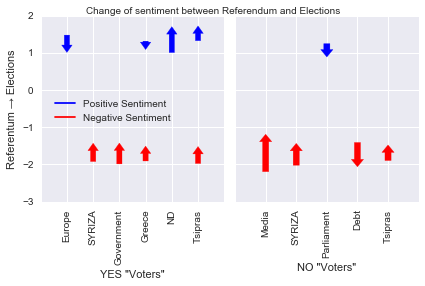

In [473]:
def compare_emotions_before_after_referendum_for_NO_voters_stat_plot_combinations():
    for yes_no in ['yes', 'no']:
        for vote_f in [yes_no_vote_1, yes_no_vote_2]:
            for stats in [['sp', 'sn'], ['sp_c', 'sn_c']]:
                print '{}    {}    {}'.format(yes_no, vote_f.__name__, stats)
                compare_emotions_before_after_referendum_for_NO_voters_stat_plot(yes_no, vote_f, stats)

#compare_emotions_before_after_referendum_for_NO_voters_stat_plot_combinations()
def compare_emotions_before_after_referendum_for_NO_voters_stat_plot_two():
    plt.figure(1)


    ax1 = plt.subplot(1,2,1)
    compare_emotions_before_after_referendum_for_NO_voters_stat_plot('yes', yes_no_vote_2, ['sp', 'sn'], ax1)
    ax1.set_ylabel(u'Referentum \u2192 Elections')
    leg_1, = ax1.plot([], [], '-', c='blue', )
    leg_2, = ax1.plot([], [], '-', c='red', )
    #ax2 = plt.subplot(1,2,2, sharey=ax1)
    ax2 = plt.subplot(1,2,2)
    compare_emotions_before_after_referendum_for_NO_voters_stat_plot('no', yes_no_vote_2, ['sp', 'sn'], ax2)
    ax2.get_yaxis().set_ticklabels([])
    
    plt.legend([leg_1, leg_2], ["Positive Sentiment", "Negative Sentiment"], loc=1, bbox_to_anchor=(-0.5, 0.6, 0.2, 0))
    plt.suptitle(u'Change of sentiment between Referendum and Elections')
    
    plt.tight_layout()
    plt.savefig('plot21.eps')
compare_emotions_before_after_referendum_for_NO_voters_stat_plot_two()
        
        


## Figure 3. Variation of YES/NO percentage overtime

Reviewer's comment:
Plots and axis labelling to be improved (data are from 25 or 27 of June? In Fig 3 why 30 Jun is missing?).

Using: ../../referendum_elections/hashtags_for_entities_v20160405.txt
('Loading file:', 'plot_variation_YES_NO_percentage.json')
[1435222800.0, 1435309200.0, 1435395600.0, 1435482000.0, 1435568400.0, 1435654800.0, 1435741200.0, 1435827600.0, 1435914000.0, 1436000400.0, 1436086800.0]
['25 Jun', '26 Jun', '27 Jun', '28 Jun', '29 Jun', '30 Jun', ' 1 Jul', ' 2 Jul', ' 3 Jul', ' 4 Jul', ' 5 Jul']
Using fontsize: 7


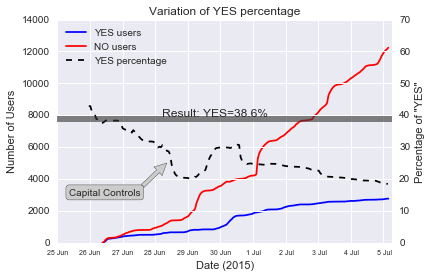

In [318]:
def variation_YES_NO_percentage():
    
    #Load older version of hastags
    ht = yes_no_entities()
    
    users_ht = {}
    start_time = None
    duration = 60 * 60 # One hour 
    to_plot = []
    
    fn_1 = 'plot_variation_YES_NO_percentage.json'
    
    if os.path.exists(fn_1):
        print ("Loading file:", fn_1)
        with open(fn_1) as f:
            to_plot = json.load(f)
    
    else:
        for item in merge_tweets_sentiment('referendum'):
        
            this_time = item['date']
        
            #Remove tweets BEFORE the announcement of the referendum
            #Interesting very few tweets exist that predicted(?) that a referendum will be announced.
            if this_time < 1435288026.0: 
                continue
        
            #item_entities = set(item['hashtag_entites']) | set(item['text_entities'])
            item_hashtags = item['ht']
        
            username = item['un']
            if not username in users_ht:
                users_ht[username] = {'yes': 0, 'no': 0, 'both': 0, 'none': 0}
        
            #Every <duration> we collect user stats
            if not start_time:
                start_time = this_time
        
            elif this_time - start_time > duration:
                start_time = this_time
            
                yes_users = len(filter(lambda x : x['yes'] > 0 and x['no'] == 0, users_ht.values()))
                no_users = len(filter(lambda x : x['yes'] == 0 and x['no'] > 0, users_ht.values()))
                yes_users_multi = len(filter(lambda x : x['yes'] > x['no'], users_ht.values()))
                no_users_multi = len(filter(lambda x : x['no'] > x['yes'], users_ht.values()))
            
                to_plot.append([start_time, {'yes_users': yes_users, 'no_users': no_users, 'yes_users_multi':yes_users_multi, 'no_users_multi':no_users_multi}])
            
            #yes_voter = 'voteyes' in item_entities
            yes_voter = len([x for x in item_hashtags if x in ht['yes']]) > 0
            no_voter = len([x for x in item_hashtags if x in ht['no']]) > 0
    
            if not yes_voter and not no_voter:
                users_ht[username]['none'] += 1
            elif yes_voter and no_voter:
                users_ht[username]['both'] += 1
            elif yes_voter and not no_voter:
                users_ht[username]['yes'] += 1
            elif not yes_voter and no_voter:
                users_ht[username]['no'] += 1
        
        with open(fn_1, 'w') as f:
            print 'Saving..'
            json.dump(to_plot, f, indent=4)
            print ('Created file:', fn_1)

    # PLOTTING
    fig, ax = plt.subplots()
    #start_from = 1.43539e9
    #start_from = 1.43510e9
    start_from = 0
    
    yes_key = 'yes_users'
    no_key = 'no_users'
    perc = [(100.0 * float(x[1][yes_key])/float(x[1][yes_key] + x[1][no_key]) if x[1][yes_key] + x[1][no_key] > 0 else 0.0 ) for x in to_plot if x[0] > start_from]
    X = [x[0] for x in to_plot if x[0] > start_from]

    leg_yes, = ax.plot(X, [x[1][yes_key] for x in to_plot if x[0] > start_from], '-b')
    leg_no, = ax.plot(X, [x[1][no_key] for x in to_plot  if x[0] > start_from], '-r')
    
    ax2 = ax.twinx()
    
    perc_to_plot = [(x,y) for x, y in zip(X, perc) if x > 1435395600]
    
    #leg_perc, = ax2.plot(X, perc, '--k')
    leg_perc, = ax2.plot([x[0] for x in perc_to_plot], [x[1] for x in perc_to_plot], '--k')
    ax2.plot([X[0]-100000, X[-1]+100000], [38.7, 38.7], '-g', linewidth=6, alpha=0.6, color='0.2')
    ax2.text(1.43557e9, 39.6, 'Result: YES=38.6%', fontsize=12)
    
    ax.set_title('Variation of YES percentage')
    ax.set_xlabel('Date (2015)')
    ax.set_ylabel('Number of Users')
    ax2.set_ylabel('Percentage of "YES"')
    ax2.set_ylim((0.0, 70.0))
    #ax.set_xlim((X[0]-10000, X[-1] + 10000))
    ax.set_xlim((X[0]-20000, X[-1] + 10000))
    
    ax2.annotate('Capital Controls', xy=(1.43558e9, 25.0), xytext=(1.43535e9, 15.0),
        arrowprops=dict(facecolor='0.8', 
            #shrink=0.05,
                    ),
        bbox=dict(boxstyle="round", fc="0.8"),
        )

    #fix_time_ticks(ax, string_time='%e %b')
    
    epochs = []
    #labels = []
    for day,month in ((25, 6), (26,6), (27,6), (28,6), (29,6), (30,6), (1,7), (2,7), (3,7), (4,7), (5,7)):
        e = float(datetime.datetime(2015, month, day, 12, 0, 0).strftime('%s'))
        epochs.append(e)
    # .strftime('%s')
    ax.set_xticks(epochs)
    fix_time_ticks(ax, string_time='%e %b', fontsize=7)
    
    plt.legend([leg_yes, leg_no, leg_perc], ['YES users', 'NO users', 'YES percentage'], loc=2)
    plt.savefig('plot_variation_YES_NO_percentage.eps')
    ax
                
variation_YES_NO_percentage()

## Sarcasm percentages

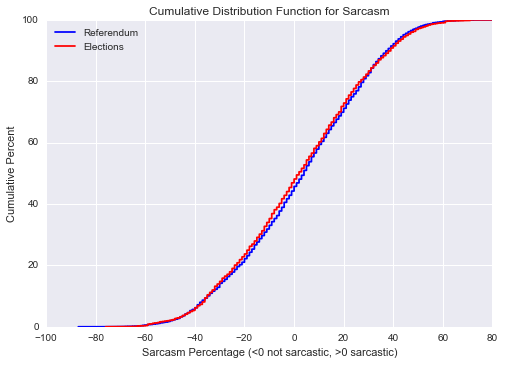

In [50]:
def plot_22():
    # https://stackoverflow.com/questions/24575869/read-file-and-plot-cdf-in-python
    referendum_sarcasm = [item['sarcasm']['percentage'] for item in merge_tweets_sentiment('referendum')]
    sorted_ref_data = np.sort(referendum_sarcasm)
    
    elections_sarcasm = [item['sarcasm']['percentage'] for item in merge_tweets_sentiment('elections')]
    sorted_ele_data = np.sort(elections_sarcasm)
    
    print "Percentage of ref tweets with sarcasm > 20:"
    print len(sorted_ref_data[sorted_ref_data>20])/float(len(sorted_ref_data)-1)
    
    print "Percentage of ele tweets with sarcasm > 20:"
    print len(sorted_ele_data[sorted_ele_data>20])/float(len(sorted_ele_data)-1)
    
    fig, ax = plt.subplots()
    yvals_ref=100.0 * np.arange(len(sorted_ref_data))/float(len(sorted_ref_data)-1)
    yvals_ele=100.0 * np.arange(len(sorted_ele_data))/float(len(sorted_ele_data)-1)
    leg_ref, = ax.plot(sorted_ref_data,yvals_ref, c='b')
    leg_ele, = ax.plot(sorted_ele_data,yvals_ele, c='r')
    plt.legend([leg_ref, leg_ele], ['Referendum', 'Elections'], loc=2)
    ax.set_xlabel('Sarcasm Percentage (<0 not sarcastic, >0 sarcastic)')
    ax.set_ylabel('Cumulative Percent')
    ax.set_title('Cumulative Distribution Function for Sarcasm')
    plt.savefig('plot_22.eps')
    plt.savefig('plot_22.png')
    ax
    
plot_22()

## Show examples of tweets from various categories

In [91]:
yes_set = set(map(unicode.lower, yes_no_entities['yes']))
no_set = set(map(unicode.lower, yes_no_entities['no']))

def item_entities(item):
    return set(item['hashtag_entites'] + item['text_entities'])

def is_yes_item(item):
    return not (not (item_entities(item) & yes_set)) # the not (not..) part is to convert fast from set to boolean

def is_no_item(item):
    return not (not (item_entities(item) & no_set))

def example_of_tweets(n, kind, filter_):

    shown = []
    item_c = 0
    
    for item in merge_tweets_sentiment(kind):
        item_c += 1

        text = item['original_text']
    
        if filter_(item):
            if not text in shown:
                shown.append(text)
                print text
                
        if len(shown) > n:
            break
    

10 "YES" tweets from referendum:

In [92]:
example_of_tweets(10, 'referendum', lambda item : is_yes_item(item) )

Reading json tweets from: ../../referendum_elections/ht_common_final_greek_sorted_reversed.json
Opening sentiment filename: ../../referendum_elections/ht_common_final_greek_sorted_reversed_with_SENTIMENT_20160419.txt
Εδω να πω πως αυριο βγαζω στη φορα λιστα με ολους τους #Menoume_Evropi εδω στα Πατησια #dimopsifisma
Έχω σχέδιο.Καλούμε #Menoume_evropi μια μέρα πριν το #dimopsifisma μοιράζουμε Aperol Spritz με αλογοηρεμιστικά μετά ξυπνάνε κ είμαστε Β.Κορεα
Μη δαιμονοποιείτε το #dimopsifisma... #menoume_evropi δεν θέλετε;
Να λοιπόν τι γίνεται στην Ευρώπη #referendum http://t.co/dAcMFGIXPE
ΚΚΕ στο #Σύνταγμα.
#Greece #dimopsifisma #syriza_sano #mnimonio_tsipra #Menoume_Evropi #Athens #Communist http://t.co/3pb4xYlJwV
Μεγάλη τσαντίλα η Μαριέτα για το #dimopsifisma. Άντε να βρεις τώρα 5.000.000 #Menoume_Evropi
τι θα κάνει το κίνημα #Menoume_Evropi με το #dimopsifisma ;
Αποδοχή ή απόρριψη της πρότασης ;;;; Alexis σόρρυ αλλά αν κρίνω από το #Menoume_Evropi το έχεις χαμένο το παιχνίδι... 
#dimop

10 "YES" tweets from referendum:

In [93]:
example_of_tweets(10, 'referendum', lambda item : is_yes_item(item) )

Reading json tweets from: ../../referendum_elections/ht_common_final_greek_sorted_reversed.json
Opening sentiment filename: ../../referendum_elections/ht_common_final_greek_sorted_reversed_with_SENTIMENT_20160419.txt
Εδω να πω πως αυριο βγαζω στη φορα λιστα με ολους τους #Menoume_Evropi εδω στα Πατησια #dimopsifisma
Έχω σχέδιο.Καλούμε #Menoume_evropi μια μέρα πριν το #dimopsifisma μοιράζουμε Aperol Spritz με αλογοηρεμιστικά μετά ξυπνάνε κ είμαστε Β.Κορεα
Μη δαιμονοποιείτε το #dimopsifisma... #menoume_evropi δεν θέλετε;
Να λοιπόν τι γίνεται στην Ευρώπη #referendum http://t.co/dAcMFGIXPE
ΚΚΕ στο #Σύνταγμα.
#Greece #dimopsifisma #syriza_sano #mnimonio_tsipra #Menoume_Evropi #Athens #Communist http://t.co/3pb4xYlJwV
Μεγάλη τσαντίλα η Μαριέτα για το #dimopsifisma. Άντε να βρεις τώρα 5.000.000 #Menoume_Evropi
τι θα κάνει το κίνημα #Menoume_Evropi με το #dimopsifisma ;
Αποδοχή ή απόρριψη της πρότασης ;;;; Alexis σόρρυ αλλά αν κρίνω από το #Menoume_Evropi το έχεις χαμένο το παιχνίδι... 
#dimop

10 election tweets with a sarcasm level between 0% and 20%

In [95]:
example_of_tweets(10, 'elections', lambda item : 0<item['sarcasm']['percentage']<20 ) # a<b<c is valid in python!

Reading json tweets from: ../../referendum_elections/ht_sorted_unique.json
Opening sentiment filename: ../../referendum_elections/ht_sorted_unique_with_SENTIMENT_20160419.txt
"Δεν είναι απαραίτητες οι εκλογές, λέει ο άλλος. Το έχουμε καταλάβει" #protoplano #toixos #ekloges #ekloges2015 http://t.co/HH9PGWju4z
Να μην επιτρέψετε, στους υπόλογους για τα Μνημόνια, να ακυρώσουν την ελπίδα σας, να ματαιώσουν τις προσδοκίες σας. #syriza #ekloges2015
Kαθαρή και ισχυρή εντολή για να υλοποιήσουμε το «Πρόγραμμα της Θεσσαλονίκης». Την μόνη ελπίδα του λαού μας #syriza #ekloges2015
Κυρία Χούκλη, έριξαν τη χώρα στα βράχια οι έμπειροι. Ας αφήσετε εμάς τους άπειρους, να πάρουμε την ευκαιρία #syriza #ekloges2015
Ο κ. Σαμαράς δήλωσε ότι θα ελαφρύνει τις δόσεις του ΕΝΦΙΑ;
Και αν η τρόικα του πει όχι τι θα κάνει;
Μονομερείς ενέργειες ;  #ekloges2015
ΚΛΑΙΩ ΡΕ ΜΑΛΑΚΕΣ @leftgr #tsipras #ekloges2015 #syriza Ο ΣΥΡΙΖΑ θα καταργήσει το 2015 τον ΕΝΦΙΑ
Οι ελληνικές κυβερνήσεις αποδέχτηκαν την εφαρμογή των Μνημονίων.

10 election tweets with a sarcasm level above 40%

In [96]:
example_of_tweets(10, 'elections', lambda item : item['sarcasm']['percentage']>40 )

Reading json tweets from: ../../referendum_elections/ht_sorted_unique.json
Opening sentiment filename: ../../referendum_elections/ht_sorted_unique_with_SENTIMENT_20160419.txt
και το hashtag ποιό θα είναι; #ekloges2015_round2 #ekloges
Ο @atsipras θα προκηρύξει σήμερα εκλογές. Δηλαδή για να καταλάβω... η Ελπίδα ήρθε; θα έρθει; ή μας προσπέρασε; #ekloges2015 #asktsipras
Στις επόμενες εκλογές θα πάω για μπάνιο...ψηφίστε οι υπόλοιποι.Καλημερα σας.
#tsipras #ekloges2015_round2
είσαι πολύ μικρός για να είσαι πρωθυπουργός, Αλέξη #diplis #mnimonio3 #ekloges2015_round2
το παρον ακκαου τη μερα τον εκλογών θα κανει βουτιες στη θαλασσα και θα πίνει τσίπουρα #ekloges2015_round2
Τι να ξεκινήσει η σχολική χρονιά με καταλήψεις, τι με εκλογές... Στο σάντουιτς να βάζουνε μαρούλι απαιτεί ο λαός! #ekloges2015
Δε πρόλαβε ο ΧΑΙ(γ)ΚΑΛΗΣ να γίνει υπουργός και πάτε σε εκλογές... Ε δε τρώγεστε... #ekloges2015
Χάθηκε ο κόσμος να προκηρυχθεί κι ένα πρόωρο mundial; Ή, έστω, ένα τοσοδούλι πρόωρο Euro; #eleos #ekloge

## Figure 1. Frequency of tweets per hour

In [108]:
def figure_1():
	min_time = 1435342648.0
	final_max_time = 1436101199.0 # 16.59 Sunday 5 July 


	if True:
		#created_at_gre = [get_created_at_unix(x) for x in status_generator('ht_greferendum_FINAL_greek.json')]
		#created_at_dim = [get_created_at_unix(x) for x in status_generator('ht_dimopsifisma_FINAL_greek.json')]

		created_at_gre = []
		created_at_dim = []

		for item in merge_tweets_sentiment('referendum'):
			hashtags = item['ht']
			date_epochs = item['date']
			
			if u'greferendum' in hashtags:
				created_at_gre.append(date_epochs)

			if u'dimopsifisma' in hashtags:
				created_at_dim.append(date_epochs)

		filename = 'plot_9.json'
		print 'Saving:', filename
		with open(filename, 'w') as f:
			json.dump([created_at_gre, created_at_dim], f)


	if True:
		filename = 'plot_9.json'
		print 'Opening:', filename
		with open(filename) as f:
			data = json.load(f)

		created_at_gre, created_at_dim = data

	if True:
		step = 60.0 # 1 minute
		bins = int((final_max_time - min_time) / step)
		print 'Bins:', bins

		fig, ax = plt.subplots()

		#sns.distplot(created_at_gre, norm_hist=False, kde=False, bins=bins, label='YES users', color='blue')

		n, bins, patches = ax.hist(created_at_gre, bins = bins, histtype='step', color='green',) # , alpha=0.5)
		n, bins, patches = ax.hist(created_at_dim, bins = bins, histtype='step', color='magenta',) #, alpha=0.5)

		ax.set_xlim((min_time, final_max_time))

		fix_time_ticks(ax, string_time='%d/%m')

		leg_gre, = ax.plot([], [], '-', color='green', linewidth=3 )
		leg_dim, = ax.plot([], [], '-', color='magenta', linewidth=3 )

		plt.legend([leg_gre, leg_dim], ['#greferendum', '#dimopsifisma'])

		#ax.set_ylim((0, 140)) # 300
		ax.set_ylim((0, 250)) # 300 
		ax.set_xlabel('Date (2015)')
		ax.set_ylabel('Tweets per hour')
		ax.set_title('Frequency of referendum tweets')


		save_figure('plot_9')

		ax

Reading json tweets from: ../../referendum_elections/ht_common_final_greek_sorted_reversed.json
Opening sentiment filename: ../../referendum_elections/ht_common_final_greek_sorted_reversed_with_SENTIMENT_20160419.txt
Lines: 10000
Lines: 20000
Lines: 30000
Lines: 40000
Lines: 50000
Lines: 60000
Lines: 70000
Lines: 80000
Lines: 90000
Lines: 100000
Lines: 110000
Lines: 120000
Lines: 130000
Lines: 140000
Lines: 150000
Lines: 160000
Lines: 170000
Lines: 180000
Lines: 190000
Lines: 200000
Lines: 210000
Lines: 220000
Lines: 230000
Lines: 240000
Lines: 250000
Lines: 260000
Lines: 270000
Lines: 280000
Lines: 290000
Lines: 300000
Missed replies: 2619
Not greek tweets: 0
Saving: plot_9.json
Opening: plot_9.json
Bins: 12642
[1435300000.0, 1435400000.0, 1435500000.0, 1435600000.0, 1435700000.0, 1435800000.0, 1435900000.0, 1436000000.0, 1436100000.0, 1436200000.0]
['26/06', '27/06', '28/06', '29/06', '01/07', '02/07', '03/07', '04/07', '05/07', '06/07']
Output filename: plot_9.png
Output filename: p

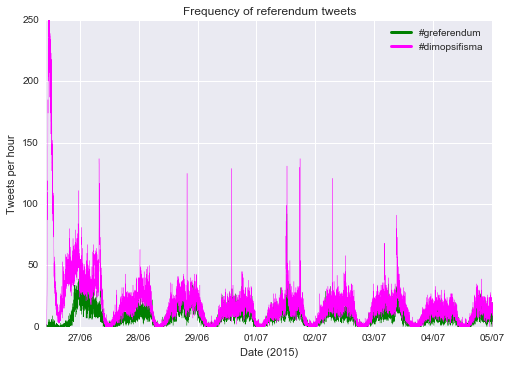

In [109]:
figure_1()

## Figure 2. Frequency of YES/NO tweets in Referendum

In [124]:
def figure_2(figure_to_plot):
	'''
	PLOT 1
	YES / NO Tendencies

	Hastags:
	#voteYes
	#voteNo
	#YesToEurope
	#NoToEurope

Peak 1:
http://www.theguardian.com/business/live/2015/jun/29/greek-crisis-stock-markets-slide-capital-controls-banks-closed-live
https://twitter.com/ThePressProject/status/615574647443193856/video/1 29 June 2015 

Peak 2:
#ΟΧΙ (NO) is not just a slogan. 
NO is a decisive step toward a better deal. #Greece #dimopsifisma #Greferendum 735
#ΟΧΙ / NO does not mean breaking w/Europe, but returning to the Europe of values.
#ΟΧΙ / NO means: strong pressure.
#Greece #dimopsifisma 691
Είναι η ευθύνη προς τους γονείς μας, προς τα παιδιά μας,προς τους εαυτούς μας.  
Είναι το χρέος μας απέναντι στην ιστορία #dimopsifisma #OXI 203

Peak 3:
https://twitter.com/vanpotamianos/status/617054822924218369/photo/1 3 July 2015 
https://www.rt.com/news/271597-greece-athens-referendum-rallies/
YES and NO 

	'''

#	'entities_from_hashtags' : '/Users/despoina/Dropbox/Despoina/hashtags_for_entities/hashtags_for_entities_v20160405.txt',
#	'entities_from_text' : '/Users/despoina/Dropbox/Despoina/entities_from_text/entities_from_text_v20160415.txt',

	ht = {}
	with codecs.open(data['entities_from_hashtags_old_1']['filename'], encoding='utf8') as f:
		print 'Using:', f.name
		for l in f:
			ls = l.replace(os.linesep, '').split()

			if ls[0][0] == '#':
				ht[ls[0][1:]] = ls[1:] # Remove #
			else:
				ht[ls[0]] = ls[1:] # DO NOT Remove #

	ht2 = {}
	ht2['yes'] = list(set(ht['voteYes'] + ht['YesToEurope']))
	ht2['no'] = list(set(ht['voteNo'] + ht['NoToEurope']))

#	ht2['yes'] = list(set(ht['voteYes'] + ht['YesEurope']))
#	ht2['no'] = list(set(ht['voteNo'] + ht['NoEurope']))


#	ht2['yes'] = list(set(ht['voteyes'] + ht['yestoeurope']))
#	ht2['no'] = list(set(ht['voteno'] + ht['notoEurope']))


	del ht
	ht = ht2

	c = 0
	start_time = None
	duration = 60 * 60 # One hour
	use_only_originals = False
	originals = {}

	to_plot_1 = []
	to_plot_2 = []

	picks = [
		[(1.43558e9, 1.43560e09), {}],
		[(1.43574e9, 1.43576e09), {}],
		[(1.43594e9, 1.43596e09), {}],
	]


	'''
2 RT @tsipras_eu: #ΟΧΙ (NO) is not just a slogan. NO is a decisive step toward a better deal. #Greece #dimopsifisma #Greferendum

2 RT @tsipras_eu: #ΟΧΙ / NO does not mean breaking w/Europe, but returning to the Europe of values.
#ΟΧΙ / NO means: strong pressure.
#Greece…


	'''

	users_ht = {}
	no_greek = 0

	if True: # Builds to_plot_1 , to_plot_2 data
		for j in get_json(data['referendum_tweets']['filename']):
			c += 1

			original_text = get_original_text(j)
			if use_only_originals:
				if original_text in originals:
					continue

			originals[original_text] = None



			if c % 10000 == 0:
				print c

			hashtags = tweet_get_hashtags(j)
			#print hashtags
			this_time = tweet_get_date_epochs(j)
			text = tweet_get_text(j)

			if not is_greek_text(text):
				not_greek += 1
				continue

			username = tweet_get_user(j)

			if not username in users_ht:
				users_ht[username] = {'yes': 0, 'no': 0, 'both': 0, 'none': 0}

			if this_time < 1435288026.0:
				continue

			#Check picks
			for p_index, p in enumerate(picks):
				if p[0][0] <= this_time <= p[0][1]:
					original_text = get_original_text(j)
					#print p_index+1, original_text
					if not original_text in p[1]:
						p[1][original_text] = 0

					p[1][original_text] += 1


			if not start_time:
				this_bucket = {'yes':0, 'no': 0, 'both': 0, 'none': 0}
				start_time = this_time
			elif this_time - start_time > duration:
				to_plot_1.append([start_time, this_bucket])
				this_bucket = {'yes':0, 'no': 0, 'both': 0, 'none': 0}
				start_time = this_time

				yes_users = len([None for v in users_ht.values() if v['yes'] > 0 and v['no'] == 0]) 
				no_users = len([None for v in users_ht.values() if v['yes'] == 0 and v['no'] > 0])

				yes_users_multi = len([None for v in users_ht.values() if v['yes'] > v['no']])
				no_users_multi = len([None for v in users_ht.values() if v['yes'] < v['no']])

				to_plot_2.append([start_time, {'yes_users': yes_users, 'no_users': no_users, 'yes_users_multi':yes_users_multi, 'no_users_multi':no_users_multi}])

			
			yes_hts = len([x for x in hashtags if x in ht['yes']])
			no_hts = len([x for x in hashtags if x in ht['no']])

			if yes_hts == 0 and no_hts == 0:
				this_bucket['none'] += 1
				users_ht[username]['none'] += 1
			elif yes_hts > 0 and no_hts > 0:
				this_bucket['both'] += 1
				users_ht[username]['both'] += 1
			elif yes_hts > 0 and no_hts == 0:
				this_bucket['yes'] += 1
				users_ht[username]['yes'] += 1
			elif yes_hts == 0 and no_hts > 0:
				this_bucket['no'] += 1
				users_ht[username]['no'] += 1
			else:
				raise Exception('This should not happen')

			#print yes_hts, no_hts
			#print this_time

			#if c > 50000:
			#	break

		if False: # Print picks text
			for p_index, p in enumerate(picks):
				s = sorted(list(p[1].iteritems()), key=lambda x:x[1], reverse=True)
				print p_index
				for x in range(10):
					print s[x][0], s[x][1]

		if True:
			#Save plot data
			suffix = '_originals' if use_only_originals else ''
			with open('plot_1%s.json' % (suffix), 'w') as f:
				f.write(json.dumps(to_plot_1) + '\n')
			print 'Saved: plot_1%s.json' % (suffix)

			with open('plot_2%s.json' % (suffix), 'w') as f:
				f.write(json.dumps(to_plot_2) + '\n')
			print 'Saved: plot_2%s.json' % (suffix)


	if False:
		with open('plot_1.json') as f:
			to_plot_1 = json.load(f)

	if False:
		with open('plot_2.json') as f:
			to_plot_2 = json.load(f)

	print 'NO GREEK TWEETS:', no_greek

	fig, ax = plt.subplots()
	#YES
	if figure_to_plot == 2: # Make plot_1
		leg_yes, = ax.plot([x[0] for x in to_plot_1], [x[1]['yes'] for x in to_plot_1], '-b')
		leg_no, = ax.plot([x[0] for x in to_plot_1], [x[1]['no'] for x in to_plot_1],  '-r')
		#leg_none, = ax.plot([x[0] for x in to_plot_1], [x[1]['none'] for x in to_plot_1],  '-k')

		plt.legend([leg_yes, leg_no], ['YES Tweets', 'NO Tweets'])
		ax.set_xlabel('Date (2015)')
		ax.set_ylabel('Number of Tweets per hour')
		ax.set_title('Frequency of YES/NO tweets in Referendum')


		ax.annotate('29 June 2015\nfirst NO demonstration', xy=(1.43558e9, 900), xytext=(1.43530e9, 1300),
			arrowprops=dict(facecolor='black', shrink=0.05, ),
			)

		ax.annotate('retweets of @atsipras\nNO promoting posts', xy=(1.43575e9, 1950), xytext=(1.43545e9, 2100),
			arrowprops=dict(facecolor='black', shrink=0.05, ),
			)


		ax.annotate('3 July 2015\nBig YES and NO demonstrations', xy=(1.43593e9, 2550), xytext=(1.43550e9, 2600),
			arrowprops=dict(facecolor='black', shrink=0.05, ),
			)


		fix_time_ticks(ax, string_time='%e %b')


		save_figure('plot_1')

	ax

Using: ../../referendum_elections/hashtags_for_entities_v20160405.txt
Reading json tweets from: ../../referendum_elections/ht_common_final_greek_sorted_reversed.json
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
Saved: plot_1.json
Saved: plot_2.json
NO GREEK TWEETS: 0
[1435200000.0, 1435300000.0, 1435400000.0, 1435500000.0, 1435600000.0, 1435700000.0, 1435800000.0, 1435900000.0, 1436000000.0, 1436100000.0]
['25 Jun', '26 Jun', '27 Jun', '28 Jun', '29 Jun', ' 1 Jul', ' 2 Jul', ' 3 Jul', ' 4 Jul', ' 5 Jul']
Output filename: plot_1.eps
Output filename: plot_1.png


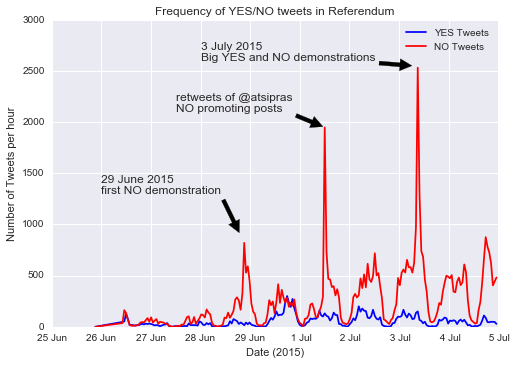

In [123]:
figure_2(2)

In [125]:
## Figure 4. Frequency of elections tweets

In [130]:
def figure_4():
	'''
	PLOT 5


Sunday, 20 September
	'''

#	'entities_from_hashtags' : '/Users/despoina/Dropbox/Despoina/hashtags_for_entities/hashtags_for_entities_v20160405.txt',
#	'entities_from_text' : '/Users/despoina/Dropbox/Despoina/entities_from_text/entities_from_text_v20160415.txt',

	ht = {}
	with codecs.open(data['entities_from_hashtags']['filename'], encoding='utf8') as f:
		for l in f:
			ls = l.replace(os.linesep, '').split()
			ht[ls[0][1:]] = ls[1:]

	ht2 = {}
	#ht2['yes'] = list(set(ht['voteYes'] + ht['YesToEurope']))
	#ht2['no'] = list(set(ht['voteNo'] + ht['NoToEurope']))
	ht2['SYRIZA'] = list(set(ht['Syriza']))
	ht2['ND'] = list(set(ht['NewDemocracy']))
	ht2['TSIPRAS'] = list(set(ht['AlexisTsipras']))
	ht2['MEIMARAKIS'] = list(set(ht['VangelisMeimarakis']))
	ht2['ANEL'] = list(set(ht['ANEL']))
	ht2['PopularUnity'] = list(set(ht['PopularUnity'])) 
	ht2['TheRiver'] = list(set(ht['TheRiver']))   
	ht2['PASOK'] = list(set(ht['PanhellenicSocialistMovement']))
	ht2['GoldenDawn'] = list(set(ht['GoldenDawn']))
	ht2['CommunistPartyOfGreece'] = list(set(ht['CommunistPartyOfGreece']))
	del ht
	ht = ht2

	
	rivals = [('SYRIZA', 'ND'), ('TSIPRAS', 'MEIMARAKIS')]

	c = 0
	start_time = None
	#duration = 60 * 60  # One hour
	duration = 60 * 60  * 24 # 12 hours

	to_plot_5 = []
	to_plot_6 = []

	if False:
		picks = [
			[(1.43558e9, 1.43560e09), {}],
			[(1.43574e9, 1.43576e09), {}],
			[(1.43594e9, 1.43596e09), {}],
		]


	'''
2 RT @tsipras_eu: #ΟΧΙ (NO) is not just a slogan. NO is a decisive step toward a better deal. #Greece #dimopsifisma #Greferendum

2 RT @tsipras_eu: #ΟΧΙ / NO does not mean breaking w/Europe, but returning to the Europe of values.
#ΟΧΙ / NO means: strong pressure.
#Greece…


	'''

	users_ht = {}
	not_greek = 0

	def empty_dict():

		ret = {}

		for rival_index, rival in enumerate(rivals):
			for rival_party in rival:
				ret[rival_party] = 0
			ret['both_%i' % rival_index] = 0
			ret['none_%i' % rival_index] = 0

		return ret


	if True: # Builds to_plot_1 , to_plot_2 data
		for j in get_json(data['elections_tweets']['filename']):
			c += 1

			if c % 10000 == 0:
				print c, tweet_get_date_text(j)

			hashtags = tweet_get_hashtags(j)
			#print hashtags
			this_time = tweet_get_date_epochs(j)
			text = tweet_get_text(j)

			if not is_greek_text(text):
				not_greek += 1
				continue

			username = tweet_get_user(j)

			if not username in users_ht:
				users_ht[username] = empty_dict()

#				users_ht[username] = {'nd': 0, 'syriza': 0, 'both': 0, 'none': 0, 'tsipras':0, 'meimarakis': 0: 'none_tm': 0, 'both_tm': 0}


			if this_time < 1440000000.0:
				continue

			if False: #Check picks
				for p_index, p in enumerate(picks):
					if p[0][0] <= this_time <= p[0][1]:
						original_text = get_original_text(j)
						#print p_index+1, original_text
						if not original_text in p[1]:
							p[1][original_text] = 0

						p[1][original_text] += 1


			if not start_time:
				this_bucket = empty_dict()
				#this_bucket = {'nd':0, 'syriza': 0, 'both': 0, 'none': 0, 'tsipras':0, 'meimarakis': 0: 'none_tm': 0, 'both_tm': 0}
				start_time = this_time
			elif this_time - start_time > duration:
				to_plot_5.append([start_time, this_bucket])
				this_bucket = empty_dict()
				#this_bucket = {'nd':0, 'syriza': 0, 'both': 0, 'none': 0, 'tsipras':0, 'meimarakis': 0: 'none_tm': 0, 'both_tm': 0}
				start_time = this_time

				#Count users
				dict_to_add = {}
				for rival_index, rival in enumerate(rivals):
					for rival_party in rival:
						dict_to_add[rival_party + '_users'] = len([None for v in users_ht.values() if v[rival_party] > 0 and sum([v[x] for x in rival if x != rival_party]) == 0])
						dict_to_add[rival_party + '_multi'] = len([None for v in users_ht.values() if v[rival_party] > sum([v[x] for x in rival if x != rival_party])])
				to_plot_6.append([start_time, dict_to_add])


#				yes_users = len([None for v in users_ht.values() if v['nd'] > 0 and v['syriza'] == 0])
#				no_users = len([None for v in users_ht.values() if v['nd'] == 0 and v['syriza'] > 0])
#				meimarakis_users = len([None for v in users_ht.values() if v['meimarakis'] > 0 and v['tsipras'] == 0])
#				tsipras_users = len([None for v in users_ht.values() if v['meimarakis'] == 0 and v['tsipras'] > 0])

#				yes_users_multi = len([None for v in users_ht.values() if v['nd'] > v['syriza']])
#				no_users_multi = len([None for v in users_ht.values() if v['nd'] < v['syriza']])
#				meimarakis_users_multi = len([None for v in users_ht.values() if v['meimarakis'] > v['tsipras']])
#				tsipras_users_multi = len([None for v in users_ht.values() if v['meimarakis'] < v['tsipras']])


#				to_plot_6.append([start_time, 
#					{'nd_users': yes_users, 
#					'syriza_users': no_users, 
#					'nd_users_multi':yes_users_multi, 
#					'syriza_users_multi':no_users_multi,
#					'meimarakis_users':meimarakis_users,
#					'tsipras_users':tsipras_users,
#					'meimarakis_users_multi': meimarakis_users_multi,
#					'tsipras_users_multi': tsipras_users_multi,
#					}])

			
			#Count tweets
			for rival_index, rival in enumerate(rivals):
				rival_dict = {}
				selected_party = None
				for rival_party in rival:
					rival_dict[rival_party] = len([None for x in hashtags if x in ht[rival_party]])
					if rival_dict[rival_party] > 0:
						selected_party = rival_party

				if all(rival_dict.values()):
					this_bucket['both_%i' % rival_index] += 1
					users_ht[username]['both_%i' % rival_index] += 1
				elif not any(rival_dict.values()):
					this_bucket['none_%i' % rival_index] += 1
					users_ht[username]['none_%i' % rival_index] += 1
				else:
					if selected_party is None:
						raise Exception('This should not happen 5691')
					else:
						this_bucket[selected_party] += 1
						users_ht[username][selected_party] += 1





#			yes_hts = len([x for x in hashtags if x in ht['ND']])
#			no_hts = len([x for x in hashtags if x in ht['SYRIZA']])
#			meimarakis_hts = len([x for x in hashtags if x in ht['MEIMARAKIS']])
#			tsipras_hts = len([x for x in hashtags if x in ht['TSIPRAS']])

#			if yes_hts == 0 and no_hts == 0:
#				this_bucket['none'] += 1
#				users_ht[username]['none'] += 1
#			elif yes_hts > 0 and no_hts > 0:
#				this_bucket['both'] += 1
#				users_ht[username]['both'] += 1
#			elif yes_hts > 0 and no_hts == 0:
#				this_bucket['nd'] += 1
#				users_ht[username]['nd'] += 1
#			elif yes_hts == 0 and no_hts > 0:
#				this_bucket['syriza'] += 1
#				users_ht[username]['syriza'] += 1
#			else:
#				raise Exception('This should not happen')

			#print yes_hts, no_hts
			#print this_time

			#if c > 50000:
			#	break

		if False: # Print picks text
			for p_index, p in enumerate(picks):
				s = sorted(list(p[1].iteritems()), key=lambda x:x[1], reverse=True)
				print p_index
				for x in range(10):
					print s[x][0], s[x][1]
	if False:
		with open('plot_5.json') as f:
			to_plot_5 = json.load(f)

	if False:
		with open('plot_6.json') as f:
			to_plot_6 = json.load(f)

	print 'NO GREEK TWEETS:', not_greek

	fig, ax = plt.subplots()
	#YES
	if True: # Make plot_1
		leg_yes, = ax.plot([x[0] for x in to_plot_5], [x[1]['ND'] for x in to_plot_5], '-b')
		leg_no, = ax.plot([x[0] for x in to_plot_5], [x[1]['SYRIZA'] for x in to_plot_5],  '-r')
		leg_meimarakis, = ax.plot([x[0] for x in to_plot_5], [x[1]['MEIMARAKIS'] for x in to_plot_5],  '--b')
		leg_tsipras, = ax.plot([x[0] for x in to_plot_5], [x[1]['TSIPRAS'] for x in to_plot_5],  '--r')


		#leg_none, = ax.plot([x[0] for x in to_plot_1], [x[1]['none'] for x in to_plot_1],  '-k')

		plt.legend([leg_yes, leg_no, leg_meimarakis, leg_tsipras], ['ND Tweets', 'SYRIZA Tweets', ' Meimarakis (ND leader) tweets', 'Tsipras (SYRIZA leader) tweets'])
		ax.set_xlabel('Date (2015)')
		ax.set_ylabel('Number of Tweets per day')
		ax.set_title('Frequency of Election tweets')
		ax.set_xlim(to_plot_5[0][0], to_plot_5[-1][0])


#		ax.annotate('29 June 2015\nfirst NO demonstration', xy=(1.43558e9, 900), xytext=(1.43530e9, 1300),
#			arrowprops=dict(facecolor='black', shrink=0.05, ),
#			)

#		ax.annotate('retweets of @atsipras\nNO promoting posts', xy=(1.43575e9, 1950), xytext=(1.43545e9, 2100),
#			arrowprops=dict(facecolor='black', shrink=0.05, ),
#			)


#		ax.annotate('3 July 2015\nBig YES and NO demonstrations', xy=(1.43593e9, 2550), xytext=(1.43550e9, 2600),
#			arrowprops=dict(facecolor='black', shrink=0.05, ),
#			)


		fix_time_ticks(ax, string_time='%e %b')

		#Save plot data
		with open('plot_5.json', 'w') as f:
			f.write(json.dumps(to_plot_5) + '\n')
		print 'Saved: plot_5.json'

		save_figure('plot_5')

	if False: # Make plot_2

		#start_from = 1.43539e9

		if False:
			yes_key = 'yes_users_multi'
			no_key = 'no_users_multi'
		if True:
			yes_key = 'yes_users'
			no_key = 'no_users'



		perc = [(100.0 * float(x[1][yes_key])/float(x[1][yes_key] + x[1][no_key]) if x[1][yes_key] + x[1][no_key] > 0 else 0.0 ) for x in to_plot_2 if x[0] > start_from]

		#X = [x[0] for x in to_plot_2 if x[0] > start_from]
		X = [x[0] for x in to_plot_6]



		print '\n'.join(map(str, perc[-10:]))

		leg_yes, = ax.plot(X, [x[1][yes_key] for x in to_plot_2 if x[0] > start_from], '-b')
		leg_no, = ax.plot(X, [x[1][no_key] for x in to_plot_2  if x[0] > start_from], '-r')

		ax2 = ax.twinx()
		leg_perc, = ax2.plot(X, perc, '--k')
		ax2.plot([X[0]-100000, X[-1]+100000], [38.7, 38.7], '-g', linewidth=6, alpha=0.6, color='0.2')
		ax2.text(1.43557e9, 39.6, 'Result: YES=38.6%', fontsize=12)

		ax.set_title('Variation of YES percentage')
		ax.set_xlabel('Date (2015)')
		ax.set_ylabel('Number of Users')
		ax2.set_ylabel('Percentage of "YES"')
		ax2.set_ylim((0.0, 70.0))
		ax.set_xlim((X[0]-10000, X[-1] + 10000))

		ax2.annotate('Capital Controls', xy=(1.43558e9, 25.0), xytext=(1.43540e9, 20.0),
			arrowprops=dict(facecolor='0.8', 
				#shrink=0.05, 
				),
			bbox=dict(boxstyle="round", fc="0.8"),
			)


		fix_time_ticks(ax, string_time='%e %b')
		#fix_time_ticks(ax)

		plt.legend([leg_yes, leg_no, leg_perc], ['YES users', 'NO users', 'YES percentage'], loc=2)

		with open('plot_6.json', 'w') as f:
			f.write(json.dumps(to_plot_6) + '\n')
		print 'Saved: plot_6.json'

		save_figure('plot_6')


	ax


Reading json tweets from: ../../referendum_elections/ht_sorted_unique.json
10000 Thu Aug 20 17:52:47 +0000 2015
20000 Thu Aug 20 20:39:16 +0000 2015
30000 Fri Aug 21 11:15:45 +0000 2015
40000 Sat Aug 22 09:19:35 +0000 2015
50000 Mon Aug 24 09:18:23 +0000 2015
60000 Wed Aug 26 18:12:28 +0000 2015
70000 Sat Aug 29 12:07:02 +0000 2015
80000 Tue Sep 01 20:23:10 +0000 2015
90000 Fri Sep 04 17:38:24 +0000 2015
100000 Mon Sep 07 14:54:26 +0000 2015
110000 Wed Sep 09 05:32:12 +0000 2015
120000 Thu Sep 10 10:30:06 +0000 2015
130000 Fri Sep 11 17:06:11 +0000 2015
140000 Sun Sep 13 11:22:18 +0000 2015
150000 Mon Sep 14 18:31:23 +0000 2015
160000 Wed Sep 16 06:49:29 +0000 2015
170000 Fri Sep 18 04:52:12 +0000 2015
180000 Sat Sep 19 13:21:39 +0000 2015
NO GREEK TWEETS: 19143
[1440000000.0, 1440500000.0, 1441000000.0, 1441500000.0, 1442000000.0, 1442500000.0, 1443000000.0]
['19 Aug', '25 Aug', '31 Aug', ' 6 Sep', '12 Sep', '17 Sep', '23 Sep']
Saved: plot_5.json
Output filename: plot_5.eps
Output fil

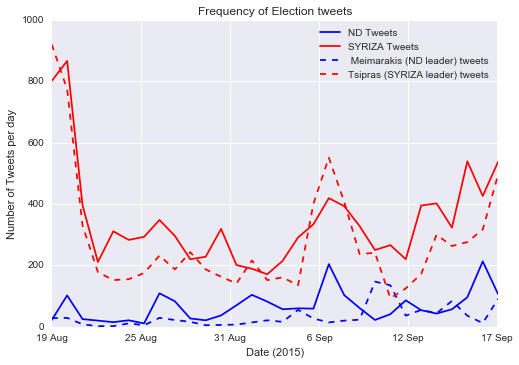

In [131]:
figure_4()

## Figure 5. Entities cooccurrence in Referendum

In [134]:
def plot_distances(
	input_filename, 
	distance_fun = lambda x : x, 
	line_ignore = lambda x : False,
	color_fun = lambda t : 'white',
	):
	'''
	input_filename should have lines TERM1 TERM2 DISTANCE
	'''

	import pygraphviz as PG
	G_gv = PG.AGraph()


	G_gv.node_attr['style']='filled'
	G_gv.node_attr['fillcolor']='white'


	added_nodes = {}
	with open(input_filename) as input_f:
		for l in input_f:
			ls = l.replace(os.linesep, '').split('__')

			term_1 = ls[0]
			term_2 = ls[1]
			raw_distance = float(ls[2])

			if line_ignore(term_1, term_2, raw_distance):
				#print 'Ignored:', ls
				continue

			term_1_dec = term_1.decode('utf-8')
			term_2_dec = term_2.decode('utf-8')

			distance = distance_fun(term_1_dec, term_2_dec, raw_distance)

			#term_1.encode('ascii', 'ignore')
			#term_2.decode('utf-8')
			#term_2.encode('ascii', 'ignore')

			#G_gv.add_edge(term_1.encode('ascii', 'ignore'), term_2.encode('ascii', 'ignore'), len=distance)
			#G_gv.add_edge(term_1.encode('utf-8'), term_2.encode('utf-8'), len=distance)

			if term_1_dec not in added_nodes:
				added_nodes[term_1_dec] = None
				G_gv.add_node(term_1_dec, fillcolor=color_fun(term_1))
			if term_2_dec not in added_nodes:
				added_nodes[term_2_dec] = None
				G_gv.add_node(term_2_dec, fillcolor=color_fun(term_2))

			G_gv.add_edge(term_1_dec, term_2_dec, len=distance)

	print 'Saving..'
	G_gv.draw( input_filename + '.png', format='png', prog='neato')
	G_gv.draw( input_filename + '.plain', format='plain', prog='neato')
	G_gv.draw( input_filename + '.eps', format='eps', prog='neato')


	print 'Saved:', input_filename + '.png'
	print 'Saved:', input_filename + '.plain'
	print 'Saved:', input_filename + '.eps'

def figure_5():

	kind = 'referendum'

	occurences = {}

	if True: # Build occurences 
		for item in merge_tweets_sentiment(kind):

			hashtag_entites = item['hashtag_entites']
			text_entities = item['text_entities']

			all_entities = sorted(list(set(hashtag_entites + text_entities)))

			if len(all_entities) < 2:
				continue

			for e1, e2 in itertools.combinations(all_entities, 2):
				key = e1 + '__' + e2
				if not key in occurences:
					occurences[key] = 0

				occurences[key] += 1

		with open('occurences_%s.json' % (kind), 'w') as f:
			json.dump(occurences, f)
		print 'Saved: occurences_%s.json' % (kind)

	if True:

		nice = {
			'greekdebt': 'debt',
			'communistpartyofgreece': 'Communist Party',
			'massmedia': 'media',
			'greekgovernment': 'Government',
			'antonissamaras': 'Antonis Samaras',
			'hellenicparliament': 'parliament',
			'theriver' : 'The River',
			'stavrostheodorakis': 'Stavros Theodorakis',
			'angelamerkel': 'Angela Merkel',
			'alexistsipras': 'Alexis Tsipras',
			'jeanclaudejuncker': 'Jean-Claude Juncker',
			'capitalcontrols': 'Capital Controls',
			'syriza': 'Syriza',
			'greekprimeminister': 'Prime Minister',
			'germany': 'Germany',
			'imf': 'IMF',
			'europe': 'Europe',
			'voteno': 'NO',
			'voteyes': 'YES',
			'eurozone': 'Eurozone',
			'yeseurope': 'YesEurope',

		}

		print 'Reading: occurences_%s.json' % (kind)
		with open('occurences_%s.json' % (kind)) as f:
			occurences = json.load(f)

		#Sorting 
		occurences_sorted = sorted(occurences.iteritems(), key=lambda x:x[1], reverse=True)
		filename = 'occurences_%s_sorted.txt' % (kind)
		print 'Saving to:', filename
		with codecs.open(filename, encoding='utf8', mode='w') as f:
			for occ in occurences_sorted:

				occ_s = occ[0].split('__')

				for occ_s_i, s in enumerate(occ_s):
					if s in nice:
						occ_s[occ_s_i] = nice[s]

				if 'greece' in occ_s:
					continue

				to_print = occ_s + [unicode(occ[1])]
				f.write('__'.join(to_print) + '\n')

	if True:
		plot_distances(
			input_filename = 'occurences_%s_sorted.txt' % (kind), 
			#distance_fun = lambda e1,e2,d : np.log(13883+10-d),
			distance_fun = lambda e1,e2,d : np.log(13883+10-d) * 0.3, 
			line_ignore = lambda e1,e2,d : d<500,
			#color_fun = lambda t : 'red' if t == 'voteno' else ('blue' if t == 'voteyes' else 'white')
			color_fun = lambda t : '#FF7F50' if t == 'NO' else ('#5CB3FF' if t == 'YES' else 'white')
			)
		# OLD : ht_co_occurence.png 
		

In [135]:
figure_5()

Reading json tweets from: ../../referendum_elections/ht_common_final_greek_sorted_reversed.json
Opening sentiment filename: ../../referendum_elections/ht_common_final_greek_sorted_reversed_with_SENTIMENT_20160419.txt
Lines: 10000
Lines: 20000
Lines: 30000
Lines: 40000
Lines: 50000
Lines: 60000
Lines: 70000
Lines: 80000
Lines: 90000
Lines: 100000
Lines: 110000
Lines: 120000
Lines: 130000
Lines: 140000
Lines: 150000
Lines: 160000
Lines: 170000
Lines: 180000
Lines: 190000
Lines: 200000
Lines: 210000
Lines: 220000
Lines: 230000
Lines: 240000
Lines: 250000
Lines: 260000
Lines: 270000
Lines: 280000
Lines: 290000
Lines: 300000
Missed replies: 2619
Not greek tweets: 0
Saved: occurences_referendum.json
Reading: occurences_referendum.json
Saving to: occurences_referendum_sorted.txt
Saving..
Saved: occurences_referendum_sorted.txt.png
Saved: occurences_referendum_sorted.txt.plain
Saved: occurences_referendum_sorted.txt.eps


![occurences_referendum_sorted.txt.png](occurences_referendum_sorted.txt.png)

## Figure 9. Temporal variation of sentiment

In [140]:
def plot_sentiment(kind=None, posneg=None, ax=None, save=True, xlabel=None, ylabel=None, xticks=True, xtickfontsize=17, xtickapply=lambda x:x[1]):
	'''
	Sentiment over time 
	'''

	if not kind:
		kind='referendum'
		#kind = 'elections'
	

	to_plot_3 = {}
	originals = {}

	def correct_sarcasm(sentiment, sarcasm_percentage):
		ret = sentiment

		if sarcasm_percentage>0.0: # Correct
			if sentiment > 0.0:
				sentiment_value = (ret-1) / 4.0
			elif sentiment <0.0:
				sentiment_value = (-ret-1) / 4.0
			else:
				raise Exception('This should not happen 491266')

			#Penalize sentiment
			sentiment_value = sentiment_value - ((sarcasm_percentage/100.0) * sentiment_value)

			#Extend to previous range
			sentiment_value = 1 + (sentiment_value * 4.0)

			#Assign right sign
			if sentiment < 0:
				sentiment_value = -sentiment_value 

			ret = sentiment_value

		return ret

	def add_sentiment(entity, all_entities, this_time, sp, sn, s0, is_original, sarcasm_percentage):
		if entity in all_entities:
			if sp > 1:
				if not entity in to_plot_3:
					to_plot_3[entity] = {'sp': [], 'sn': []}
				to_plot_3[entity]['sp'].append((this_time, correct_sarcasm(sp, sarcasm_percentage), sp, is_original, sarcasm_percentage))
			

			if sn < -1:
				if not entity in to_plot_3:
					to_plot_3[entity] = {'sp': [], 'sn': [], 'sp_nc': [], 'sn_nc':[], 's0': [] }
				to_plot_3[entity]['sn'].append((this_time, correct_sarcasm(sn, sarcasm_percentage), sn, is_original, sarcasm_percentage))


	if True:
		for item in merge_tweets_sentiment(kind):

			this_time = item['date']
			sp = item['sp']
			sn = item['sn']
			s0 = item['s0']
			original_text = item['original_text']

			if this_time < 1435288026.0:
				continue

			if sp == 1 and sn == -1:
				continue

			# 634360327572951040
			text_entities = item['text_entities']
			#to_print.append(len(text_entities))
			hashtag_entites = item['hashtag_entites']

			sarcasm_percentage = item['sarcasm']['percentage']

			all_entities = list(set(text_entities+hashtag_entites))

			is_original = 1 if original_text in originals else 0
			originals[original_text] = None

			for x in all_entities:
				add_sentiment(x, all_entities, this_time, sp, sn, s0, is_original, sarcasm_percentage)
			

		if True:
			with open('plot_3_%s.json' % (kind), 'w') as f:
				json.dump(to_plot_3, f)
			print 'Saved plot_3_%s.json' % (kind)
	if True:
		if kind == 'referendum':
			with open('plot_3_referendum.json') as f: # mv plot_3.json plot_3_referendum.json
				to_plot_3 = json.load(f)
			print 'Opening: plot_3_referendum.json'
		elif kind == 'elections':
			with open('plot_3_elections.json') as f: # mv plot_3.json plot_3_elections.json 
				to_plot_3 = json.load(f)
			print 'Opening: plot_3_elections.json'

	if False: # Make CSV with sentiments for each entity
		for kind in ['elections', 'referendum']:
			with open('plot_3_%s.json' % kind) as f:
				data = json.load(f)

			for sentiment, key in [('positive', 'sp'), ('negative', 'sn')]:



				for e in data:
					print 'Kind:', kind, 'Entity:', e, 'Sentiment:', sentiment
					filename = 'sentiments__%s_%s_%s.csv' % (kind, e, sentiment)
					print 'Filename:', filename
					with open(filename, 'w') as f:
						for entry in data[e][key]:
							to_print = ','.join(map(str, entry))
							f.write(to_print + '\n')

	if False:
		# Which are the most common entities
		f = [(x, max(len(y['sp']), len(y['sn']))) for x,y in to_plot_3.iteritems()]
		fs = sorted(f, key=lambda x : x[1], reverse=True)
		for x in fs:
			print x

			'''
REFERENDUM:

(u'voteno', 42699)
(u'greece', 35298)
(u'hellenicparliament', 11479)
(u'alexistsipras', 11474)
(u'europe', 10777)
(u'voteyes', 8588)
(u'syriza', 7473)
(u'yeseurope', 6562)
(u'bank', 6449)
(u'greekprimeminister', 6095)
(u'eurozone', 5801)
(u'greekgovernment', 5689)
(u'state', 5293)
(u'capitalcontrols', 4994)
(u'massmedia', 3529)
(u'jeanclaudejuncker', 3094)
(u'communistpartyofgreece', 3036)


		'''


		'''
ELECTIONS:

(u'alexistsipras', 12173)
(u'syriza', 8256)
(u'greece', 6613)
(u'vangelismeimarakis', 3526)
(u'communistpartyofgreece', 3281)
(u'state', 3044)
(u'anel', 2800)
(u'panagiotislafazanis', 2770)
(u'popularunity', 2761)
(u'newdemocracy', 2633)
(u'zoekonstantopoulou', 2427)
(u'greekgovernment', 2207)
(u'panhellenicsocialistmovement', 2053)
(u'theriver', 1903)

		'''

	minx = []
	maxx = []

	def plot_sentiment(entity, s, color, axes, linestyle = '-'):

		if entity == 'Tsipras':
			entity = 'AlexisTsipras'
		if entity == 'Troika':
			entity = 'EuropeanTroika'
		if entity == 'Communist Party':
			entity = 'communistpartyofgreece'
		if entity == 'New Democracy':
			entity = 'newdemocracy'
		if entity == 'Government':
			entity = 'greekgovernment'
		if entity == 'PASOK':
			entity = 'panhellenicsocialistmovement'
		if entity == 'Varoufakis':
			entity = 'YanisVaroufakis'
		if entity == u'Schäuble':
			entity = 'WolfgangSchauble'
		if entity == 'Capital Controls':
			entity = 'CapitalControls'
		if entity == 'Debt':
			entity = 'GreekDebt'

		entity = entity.lower()

		X = [x[0] for x in to_plot_3[entity][s]]

		if s == 'sp':
			Y = [x[1] for x in to_plot_3[entity][s]]
		elif s == 'sn':
			Y = [-x[1] for x in to_plot_3[entity][s]]
		else:
			raise Exception('sdgdfg34234')

		#data = zip(X, Y)[0:100]
		data = zip(X, Y)
		df = pd.DataFrame(data, columns=["Date", "Y"])
		print 'Entity: %s Data points: %i' % (entity, len(data))

		print print_now_2(), 'Before regression..'
		#axes.set(ylim=(1.6, 2.8))
		g = seaborn.regplot(x="Date", y='Y', data=df, ax=axes, 
			lowess=True,
			truncate=False,
			#order = 2,
			#x_ci = None,
			#scatter_kws={'s':2, 'color':'k'},
			line_kws={'color': color, 'linestyle': linestyle}, # 'alpha': line_alpha, 'linestyle': linestyle, 'linewidth': 1}
			scatter=False,
			)
		#axes.set(ylim=(1.6, 2.8))
		
		#leg, = plt.plot([], [], color= color, linestyle= linestyle)
		leg, = plt.plot([], [], '.', color= color)

		#print g
		#print dir(g)
		print print_now_2(), 'After regression'

		#print X, Y

		minx.append(min(X))
		maxx.append(max(X))

		return leg


	#matplotlib.rcParams.update({'font.size': 22})
	if True: # Plot
		if not posneg:
			#posneg = 'positive'
			posneg = 'negative'
		try:
			seaborn.set_style("ticks")
		except NameError as e:
			print 'WARNING: SEABORN IS NOT IMPORTED!!!!'
		if not ax:
			fig, ax = plt.subplots() 

		if kind == 'referendum':
			e_list = [
			('Tsipras', 'blue'),
			('hellenicparliament', 'red'),
			('europe', 'green'),
			('bank', 'm'),
			('eurozone', 'y'),
			]

		elif kind == 'elections': # Elections
			e_list = [
			('Tsipras', 'blue'),
			('syriza', 'red'),
			('greece', 'green'),
			('vangelismeimarakis', 'm'),
			('communistpartyofgreece', 'y'),
			]

		#ax2 = ax.twinx()

		legends = []
		for e, e_color in e_list:
			if posneg == 'positive':
				leg = plot_sentiment(e, 'sp', e_color, ax)
			elif posneg == 'negative':
				leg = plot_sentiment(e, 'sn', e_color, ax)
			legends.append(leg)

			#plot_sentiment(e, 'sn', e_color, ax2, linestyle='--')

		x_min = min(minx)
		x_max = max(maxx)
		ax.set_xlim((x_min, x_max))
		if kind == 'referendum':
			if posneg == 'positive':
				ax.set(ylim=(1.6, 2.8))
			elif posneg == 'negative':
				ax.set(ylim=(1.74, 2.16))
		elif kind == 'elections':
			pass
		#ax.set_ylim((1.0, 4.5))
		#ax.set_xlabel('Date (2015)', fontsize=17)
		#ax.set_xlabel('Date (2015)')
		ax.set_xlabel('')
		if posneg == 'positive':
			if not ylabel:
				ylabel = 'Positive Sentiment'
			ax.set_ylabel(ylabel, fontsize=17)

		elif posneg == 'negative':
			if not ylabel:
				ylabel = 'Negative Sentiment'
			ax.set_ylabel(ylabel, fontsize=17)
		#ax.set_title('Variation of Positive Sentiment in %s' % (kind))
		print 'X LIMITS:', ax.get_xlim()
		print 'Y LIMITS:', ax.get_ylim()

		if kind == 'referendum':
			if posneg == 'positive':
				if not xlabel:
					xlabel = 'Variation of Positive Sentiment in %s' % (kind)
				ax.text(1435443938.0, 2.85, xlabel, fontsize=17 )
				if save:
					plt.legend(legends, ['Tsipras', 'Parliament', 'Europe', 'Bank', 'Eurozone'], fontsize=17) # 
				else:
					plt.legend(legends, ['Tsipras', 'Parliament', 'Europe', 'Bank', 'Eurozone'], bbox_to_anchor=(-.05, -0.22, 1.0, -.138), loc=3, ncol=3, mode="expand", borderaxespad=0., ) # fontsize=17 $ (0., 1.02, 1., .102)
			elif posneg == 'negative':
				if not xlabel:
					xlabel = 'Variation of Negative Sentiment in %s' % (kind)
				ax.text(1435443938.0, 2.18, xlabel, fontsize=17 )
				if save:
					plt.legend(legends, ['Tsipras', 'Parliament', 'Europe', 'Bank', 'Eurozone'], bbox_to_anchor=(1.0, 1.03), fontsize=17) 
			
		if kind == 'elections':
			if posneg == 'positive':
				if not xlabel:
					xlabel = 'Variation of Positive Sentiment in %s' % (kind)
				ax.text(1440300000.0, 2.74, xlabel, fontsize=17 )
				if save:
					plt.legend(legends, ['Tsipras', 'Syriza', 'Greece', 'Meimarakis', 'Communist party'], loc=4, fontsize=17) # fontsize=17
				else:
					plt.legend(legends, ['Tsipras', 'Syriza', 'Greece', 'Meimarakis', 'Communism'], bbox_to_anchor=(-.05, -0.22, 1.1, -0.138), loc=3, ncol=3, mode="expand", borderaxespad=0.,) # fontsize=17
			elif posneg == 'negative':
				if not xlabel:
					xlabel = 'Variation of Negative Sentiment in %s' % (kind)
				if save:
					ax.text(1440300000.0, 2.65, xlabel, fontsize=17 )
				else:
					pass
					#plt.legend(legends, ['Tsipras', 'Syriza', 'Greece', 'Meimarakis', 'Communist party'], loc=2, bbox_to_anchor=(0.03, 0.93), fontsize=17) # fontsize=17 

		if xticks:
			fix_time_ticks(ax, string_time='%e %b', fontsize=xtickfontsize, apply_index=xtickapply)
		else:
			fix_time_ticks(ax, string_time='', fontsize=xtickfontsize)

		#ax2.set_ylabel('Negative Sentiment')

		if save:
			# plot_3b_ has smaller fonts 
			save_figure('plot_3c_%s_%s' % (posneg, kind)) 

			plt.show()
			#a=1/0

	if False: # Plot

		seaborn.set_style("ticks")
		fig, ax = plt.subplots()

#		ax.set_ylim((-3.0, +3.0))


		#plot_sentiment('voteno', 'sn', color='b')

		if kind == 'referendum':
			e_list = [
			#'EuropeanUnion',
			['Tsipras', -2.05, -1.75, 0, -0.05, 0, +50000],
			#['memorandum', -3, -1],
			['Debt', -2.02, -1.9, -0.5, -0.04, 0, +50000],
			['Capital Controls', -2.2, -1.5, 0, 0, -0.22, -50000],
			['Europe', -2.1, -1.91, 0, +0.02, 0, 0],
			[u'Schäuble', -2, -1.8, 0, -0.04, 0, -50000],
			['Varoufakis', -2.2, -1.85, -0.5, -0.03, -0.1, 0], 
			['Economy', -2.0, -1.7, +0.02, 0.03, -0.25, 0],
			#['Economy', -2.1, -1.9, 0.0, 0.0, -0.0, 0],
			['Troika', -2.1, -1.8, 0, -0.03, 0, +50000],
			'agreement',
			'AngelaMerkel',
			'JeroenDijsselbloem',
			'IMF'
			]
		elif kind == 'elections': # Elections
			e_list = [
				['AlexisTsipras', -2.1, -1.6, 0, -0.05, 0, 0],
				['Syriza', -2.2, -1.8, 0, 0, 0, 0],
				['Greece', -2.2, -1.9, 0, -0.07, 0, 0],
				['VangelisMeimarakis', -1.9, -1.8, 0, -0.01, 0, -500000],
				['Communist Party', -2.6, -2.3, 0, -0.13, 0, -130000],
				['New Democracy',  -2.4, -1.9, 0, -0.08, 0, -100000], 
				['Government', -1.95, -1.8, 0, -0.02, 0, 0],
				['PASOK', -2.5, -1.95, 0, -0.1, 0, 0],
			]

		all_axes = []

		height = 0.1
		for e_index, e_set in enumerate(e_list[:8]):
		#for e_index, e_set in enumerate([e_list[1]]):

			e = e_set[0]
			e_min = e_set[1]
			e_max = e_set[2]
			boost_2_y_down = e_set[3] # From_y
			move_text_y = e_set[4]
			boost_2_y_up = e_set[5] # To_y
			move_text_x = e_set[6]

			ax_new = fig.add_axes([0.09, 0.1 + (height*e_index), 0.8, height])



##########

			if True:
				#ax_new2 = ax_new.twinx()
				
				plot_sentiment(e, 'sp', 'b', ax_new)

				ax_new.set_xticks([])

				ax_new_ylim = ax_new.get_ylim()
				ax_new_ylim = (ax_new_ylim[0] + boost_2_y_down, ax_new_ylim[1] + boost_2_y_up)
				ax_new.set_ylim(ax_new_ylim)


				ax_new.yaxis.set_ticks(np.arange(ax_new_ylim[0] ,ax_new_ylim[1], (ax_new_ylim[1]-ax_new_ylim[0])/3.0 ))
				ax_new_labels = [ '%.2f' % (float(x)) if i else '' for i, x in enumerate(ax_new.get_yticks().tolist())]
				ax_new.set_yticklabels(ax_new_labels)

##########

			if True:
				ax_new2 = ax_new.twinx()


				ax_new2.set_ylim((e_min, e_max))
				plot_sentiment(e, 'sn', 'r', ax_new2)
			
		
				ax_new2.yaxis.set_ticks(np.arange(e_min, e_max, (e_max-e_min)/3.0 ))
				ax_new2_labels = [ '%.2f' % (float(x)) if i else '' for i, x in enumerate(ax_new2.get_yticks().tolist())]
				ax_new2.set_yticklabels(ax_new2_labels)

				ax_new2.set_xticks([])
				#ax_new.set_yticks([-2.5,-1.5])

				if e_index != 0:
					ax_new2.spines['bottom'].set_visible(False)

			if e_index != 0:
				ax_new.spines['bottom'].set_visible(False)
				
			#ax_new.spines['left'].set_visible(False)
			all_axes.append(ax_new)
			all_axes.append(ax_new2)
			#ax_new.text(1435960000 + move_text_x, (e_min + e_max)/2.0 + move_text_y , e,  verticalalignment='bottom', bbox={'facecolor':'white', 'alpha':0.1})
			
			if kind == 'referendum': 
				ax_new2.text(1435960000 + move_text_x, (e_min + e_max)/2.0 + move_text_y , e,  verticalalignment='bottom')
			elif kind == 'elections':
				ax_new2.text(1442200000 + move_text_x, (e_min + e_max)/2.0 + move_text_y , e,  verticalalignment='bottom')

		if kind == 'referendum':
			step = 100000
		elif kind == 'elections':
			step = 300000
		rr = range(step/2 + int(min(minx)), int(max(maxx)), step)

		print 'Minimum:', min(minx)
		print 'Maximum:', max(maxx)
		for a_index, a in enumerate(all_axes):
			a.set_xlim(min(minx), max(maxx))
			a.set_ylabel('')
			a.set_xlabel('')
			#ax.set_ylim((-2.0, +2.0))

			if a_index == 0:
				a.set_xticks(rr)
				fix_time_ticks(a, string_time='%e %b')
			elif a_index % 2 == 0:
				a.set_xticks(rr)
				ticks_a = a.get_xticks().tolist()
				ticks_a = ['' for x in ticks_a]
			#ax_new.set_yticklabels(new_ticks)
				a.set_xticklabels(ticks_a)


		ax.spines['top'].set_visible(False)
		ax.spines['right'].set_visible(False)
		ax.spines['bottom'].set_visible(False)
		ax.spines['left'].set_visible(False)
		ax.set_xticks([])
		ax.set_yticks([])

		#ax.plot([0,1], [0,1], '-')
		#ax.set_xlabel('Date (2015)')
		
		ax.text(-0.15, 0.8, 'Positive Sentiment (Blue)', rotation='vertical',)
		ax.text(1.08, 0.8, 'Negative Sentiment (Red)', rotation='vertical',)
		if kind == 'referendum':
			ax.text(0.2, 1.05, 'Variation of Sentiment in Referendum tweets')
		elif kind == 'elections':
			ax.text(0.2, 1.05, 'Variation of Sentiment in Elections tweets')

		print print_now_2(), 'Finished'

#		fix_time_ticks(ax, string_time='%e %b')

		if kind == 'referendum':
			save_figure('plot_3_referendum')
		elif kind == 'elections':
			save_figure('plot_3_elections')
		plt.show()


def figure_9():
	'''
	- Figures containing multiple panels/subfigures must be combined into one image file before submission.  https://mail.google.com/mail/u/0/#inbox/156382863ee888af 

	cp plot_3d.eps GitHub/phd/latex/referendum_plos_one/figures/
	'''

	current_plot = 0
	for posneg in ['positive', 'negative']:
		for kind in ['referendum', 'elections']:
			current_plot += 1
			ax = plt.subplot(2, 2, current_plot)

			xtickapply = lambda x : x[1]

			if current_plot == 1:
				xlabel = 'Referendun'
				ylabel = 'Positive'
				xticks = False
			elif current_plot == 2:
				xlabel = 'Elections'
				ylabel = ' '
				xticks = False
			elif current_plot == 3:
				xlabel = ' '
				ylabel = 'Negative'
				xticks = True
				xtickapply = lambda x : x[1] if not x[0]%2 else ''
			elif current_plot == 4:
				xlabel = ' '
				ylabel = ' '
				xticks = True

			plot_sentiment(kind=kind, posneg=posneg, ax=ax, save=False, xlabel=xlabel, ylabel=ylabel, xticks=xticks, xtickfontsize=9, xtickapply=xtickapply)
			plt.tick_params(axis='x', which='both', top='off', )

			if current_plot == 2:
				plt.tick_params(axis='x', which='both', bottom='off', )


	save_figure('plot_3d')
	ax


Reading json tweets from: ../../referendum_elections/ht_common_final_greek_sorted_reversed.json
Opening sentiment filename: ../../referendum_elections/ht_common_final_greek_sorted_reversed_with_SENTIMENT_20160419.txt
Lines: 10000
Lines: 20000
Lines: 30000
Lines: 40000
Lines: 50000
Lines: 60000
Lines: 70000
Lines: 80000
Lines: 90000
Lines: 100000
Lines: 110000
Lines: 120000
Lines: 130000
Lines: 140000
Lines: 150000
Lines: 160000
Lines: 170000
Lines: 180000
Lines: 190000
Lines: 200000
Lines: 210000
Lines: 220000
Lines: 230000
Lines: 240000
Lines: 250000
Lines: 260000
Lines: 270000
Lines: 280000
Lines: 290000
Lines: 300000
Missed replies: 2619
Not greek tweets: 0
Saved plot_3_referendum.json
Opening: plot_3_referendum.json
Entity: alexistsipras Data points: 4213
Wed, 28 Jun 2017 09:43:49 +0000 Before regression..
Wed, 28 Jun 2017 09:43:51 +0000 After regression
Entity: hellenicparliament Data points: 4018
Wed, 28 Jun 2017 09:43:51 +0000 Before regression..
Wed, 28 Jun 2017 09:43:52 +0000 

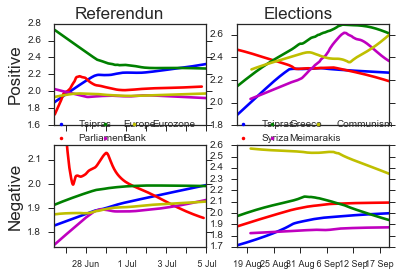

In [146]:
figure_9()

## LDA Topic Model 

The position of the clusters for LDA clustering depend on the random seed. Different runs will generate the same number of clusters and same distances. Nevertheless, the absolute locations of the clusters will differ. The functions below, plot the results from a specific LDA run. The files with the results of these runs are ``ldasave_referendum.html`` and ``ldasave_elections.html``. These files exist in this repository.

In [160]:
class My_LDA():
	def __init__(self):
		pass

	#@timer
	def fit_LDA_model(self, corpus, id2word, num_topics=50, passes=10):
		from gensim import models

		print 'Fitting the LDA model..'
		lda = models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=passes)
		return lda

	def visualize_LDA_model(self, lda, corpus, dictionary, output_filename):
		import pyLDAvis.gensim as gensimvis 
		import pyLDAvis

		print 'Visualizing LDA model..'
		vis_data = gensimvis.prepare(lda, corpus, dictionary)

		#with open('ldasave.html', 'w') as f:
		with open(output_filename, 'w') as f:
			pyLDAvis.save_html(vis_data, f)

		print 'Created:', output_filename

	def LDA(self, list_of_docs, num_topics=50, no_above=0.5, output_filename='ldasave.html'):
		dictionary, corpus = self.build_dictionary(list_of_docs, no_above=no_above)
		lda = self.fit_LDA_model(corpus, dictionary, num_topics=num_topics)
		self.visualize_LDA_model(lda, corpus, dictionary, output_filename)

	def build_dictionary(self, docs, no_below=5, no_above=0.5):
		from gensim.corpora import Dictionary, MmCorpus

		print 'Building dictionary..'
		dictionary = Dictionary(docs)
		dictionary.compactify()
		dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
		dictionary.compactify()

		print 'Building corpus..'

		corpus = [dictionary.doc2bow(doc) for doc in docs]

		return dictionary, corpus


In [158]:
def do_LDA(figure_to_plot, output_html):
	'''
	LDA for referendum
	LDA referendum

	ldasave_1.html --> No sarcasm filtering & remove voteyes, voteno
	ldasave_2.html --> Sarcasm > 5% & remove voteyes, voteno
	ldasave_3.html --> Sarcasm filtering, add voteyes, add noteno
	'''
	
	if figure_to_plot == 10:
		kind = 'referendum'
	elif figure_to_plot == 11:
		kind = 'elections'
	else:
		raise Exception('Unknown value for figure_to_plot parameter')

	c = 0

	sentiment_entities = {}

	entity_collection = []

	for item in merge_tweets_sentiment(kind):
		#print item['sarcasm']['percentage'],  item['sarcasm']['score'] 

		c += 1

		this_time = item['date']

		if this_time < 1435288026.0:
			continue

		#this_entities = []

		if False:
			for level in [1,2]:
				for entity_set in item[str(level)]:
					for entity_name in entity_set[1]:
						if entity_name[0] == '#':
							entity_name = entity_name[1:]

							#if entity_name in ['referendum', 'dimopsifisma', 'voteYes', 'voteNo']:
							#	continue

							if entity_name in ['referendum', 'dimopsifisma']:
								continue


							#if True: # Remove sarcasm
							#	if item['sarcasm']['percentage'] > 5.0:
							#		continue
							this_entities.append(discretize_sarcasm(item['sarcasm']['percentage']))

							if not entity_name in this_entities:
								this_entities.append(entity_name)

		if True:
			if item['sarcasm']['percentage'] > 5.0:
				continue

		if True:
			text_entities = item['text_entities']
			hashtag_entites = item['hashtag_entites']

		all_entities = list(set(text_entities + hashtag_entites))
		
		if False:
			all_entities = [x for x in all_entities if not x in ['referendum', 'dimopsifisma', 'voteyes', 'voteno']]

		if True:
			all_entities = [x for x in all_entities if not x in ['referendum', 'dimopsifisma']]

		if kind == 'referendum':
			if (('voteyes' in all_entities) or ('yeseurope' in all_entities)) and (('voteno' in all_entities) or ('noeurope' in all_entities)):
				continue

		if len(all_entities) > 1:
			#print c, ' '.join(all_entities)

			if True:
				#Store sentiment entities
				if item['sp'] != 1:
					for x in all_entities:
						if not x in sentiment_entities:
							sentiment_entities[x] = {'sp': [], 'sn':[]}
						sentiment_entities[x]['sp'].append( (item['sp']-1)/float(4) )
				if item['sn'] != -1:
					for x in all_entities:
						if not x in sentiment_entities:
							sentiment_entities[x] = {'sp': [], 'sn': []}
						sentiment_entities[x]['sn'].append( (-item['sn']-1)/float(4))


			entity_collection.append(all_entities)
	
	if True:
		print 'Saving sentiment entities'
		for x in sentiment_entities:
			if sentiment_entities[x]['sp']:
				sentiment_entities[x]['sp'] = np.mean(sentiment_entities[x]['sp'])
			if sentiment_entities[x]['sn']:
				sentiment_entities[x]['sn'] = np.mean(sentiment_entities[x]['sn'])
		with open('sentiment_entities_%s.json' % (kind), 'w') as f:
			f.write(json.dumps(sentiment_entities))
		print 'Saved: sentiment_entities.json'
		#a=1/0

	print print_now_2(), 'Performing LDA..'
	lda = My_LDA()
	lda.LDA(entity_collection, num_topics=5, output_filename='ldasave_{}_{}.html'.format(kind, output_html)) # , no_above=0.7)
	print print_now_2(), 'Done LDA'

In [167]:
do_LDA(10, 'run1')

Reading json tweets from: ../../referendum_elections/ht_common_final_greek_sorted_reversed.json
Opening sentiment filename: ../../referendum_elections/ht_common_final_greek_sorted_reversed_with_SENTIMENT_20160419.txt
Lines: 10000
Lines: 20000
Lines: 30000
Lines: 40000
Lines: 50000
Lines: 60000
Lines: 70000
Lines: 80000
Lines: 90000
Lines: 100000
Lines: 110000
Lines: 120000
Lines: 130000
Lines: 140000
Lines: 150000
Lines: 160000
Lines: 170000
Lines: 180000
Lines: 190000
Lines: 200000
Lines: 210000
Lines: 220000
Lines: 230000
Lines: 240000
Lines: 250000
Lines: 260000
Lines: 270000
Lines: 280000
Lines: 290000
Lines: 300000
Missed replies: 2619
Not greek tweets: 0
Saving sentiment entities
Saved: sentiment_entities.json
Wed, 28 Jun 2017 11:21:57 +0000 Performing LDA..
Building dictionary..
Building corpus..
Fitting the LDA model..
Visualizing LDA model..
Created: ldasave_referendum_run1.html
Wed, 28 Jun 2017 11:24:51 +0000 Done LDA


In [166]:
do_LDA(11, 'run1')

Reading json tweets from: ../../referendum_elections/ht_sorted_unique.json
Opening sentiment filename: ../../referendum_elections/ht_sorted_unique_with_SENTIMENT_20160419.txt
Lines: 10000
Lines: 20000
Lines: 30000
Lines: 40000
Lines: 50000
Lines: 60000
Lines: 70000
Lines: 80000
Lines: 90000
Lines: 100000
Lines: 110000
Lines: 120000
Lines: 130000
Lines: 140000
Lines: 150000
Lines: 160000
Lines: 170000
Lines: 180000
Missed replies: 1140
Not greek tweets: 18895
Saving sentiment entities
Saved: sentiment_entities.json
Wed, 28 Jun 2017 11:17:18 +0000 Performing LDA..
Building dictionary..
Building corpus..
Fitting the LDA model..
Visualizing LDA model..
Created: ldasave_elections_run1.html
Wed, 28 Jun 2017 11:18:25 +0000 Done LDA


In [149]:
def figure_11(figure_to_plot):
	'''
	process ldasave.html 
	Plot circles
	'''
	import matplotlib.patches as mpatches
	from matplotlib.collections import PatchCollection

	if figure_to_plot == 10:
		kind = 'referendum'
	elif figure_to_plot == 11:
		kind = 'elections'
	else:
		raise Exception('Invalid value in figure_to_plot parameter')

	add_colorbars = False
	add_sentiment_color_in_cicles = False
	voteno_x_offset = 0.18
	remove_axes = True
	

	with open('ldasave_%s.html' % (kind)) as f:
		for l in f:
			if 'var ldavis_' in l:
				l2 = re.sub(r'var ldavis_el[\d]+_data = ', '', l)
				l2 = l2.replace(';', '')
				d = json.loads(l2)

	#print json.dumps(d, indent=4)

	X = d['mdsDat']['x']
	Y = d['mdsDat']['y']
	freq = d['mdsDat']['Freq']
	topic_label = d['mdsDat']['topics']

	#print X,Y,freq

	topic = d['token.table']['Topic']
	fr = d['token.table']['Freq']
	term = d['token.table']['Term']

	#print len(topic), len(fr), len(term)

	counts_name = d['tinfo']['Term']
	counts_freq = d['tinfo']['Freq']

	assert len(counts_name) == len(counts_freq)

	term_freq = dict(zip(counts_name, counts_freq))

	with open('sentiment_entities_%s.json' % (kind)) as f:
		sentiment_entities = json.load(f)
	print 'Opening: sentiment_entities_%s.json' % (kind)

	topic_color = {}
	for x, y, z in zip(topic, fr, term):

		if not z in sentiment_entities:
			continue


		if not x in topic_color:
			topic_color[x] = {'sp': [], 'sn': [], 'sum': 0}

		sp = sentiment_entities[z]['sp']
		sn = sentiment_entities[z]['sn']
		this_counts = term_freq[z] * y
		topic_color[x]['sp'].append((sp if type(sp) is float else 0.0, this_counts))
		topic_color[x]['sn'].append((sn if type(sn) is float else 0.0, this_counts))
		topic_color[x]['sum'] += this_counts

	for x in topic_color:

		#print '========================'
		#print topic_color[x]['sp']
		#print '========================'
		topic_color[x]['final_sp'] = sum([ (y[1]/float(topic_color[x]['sum'])) * y[0] for y in topic_color[x]['sp']])
		topic_color[x]['final_sn'] = sum([ (y[1]/float(topic_color[x]['sum'])) * y[0] for y in topic_color[x]['sn']])

		print 'Topic:', x, 'sp:', topic_color[x]['final_sp'], 'sn:', topic_color[x]['final_sn']

	min_sp = min([topic_color[x]['final_sp'] for x in topic_color])
	max_sp = max([topic_color[x]['final_sp'] for x in topic_color])
	min_sn = min([topic_color[x]['final_sn'] for x in topic_color])
	max_sn = max([topic_color[x]['final_sn'] for x in topic_color])

	for x in topic_color:
		topic_color[x]['final_sp'] = (((topic_color[x]['final_sp'] - min_sp) * (0.9 - 0.1)) / (max_sp - min_sp)) + 0.1
		topic_color[x]['final_sn'] = (((topic_color[x]['final_sn'] - min_sn) * (0.9 - 0.1)) / (max_sn - min_sn)) + 0.1


	seaborn.set_style("white")
	#seaborn.set_context(rc = {'patch.linewidth': 0.0})
	#seaborn.despine()
	fig, ax = plt.subplots()

	patches = []

#	ax.set_xlim((-0.6, 0.8))


	cb_pos_x = 0.19
	cb_pos_y = 0.18
	cb_width = 0.02
	cb_height = 0.2
	cb_fz = 8

	cmap_left = plt.cm.Blues
	cax_left = fig.add_axes([cb_pos_x, cb_pos_y, cb_width, cb_height])
	norm_left = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
	cb_left = matplotlib.colorbar.ColorbarBase(cax_left, cmap=cmap_left, norm=norm_left, spacing='proportional', ticks=[0, 1])
	cb_left.ax.yaxis.set_ticks_position('left')
#	cb_left.ax.set_yticklabels(['Week\nPositive\nSentiment', 'Strong\nPositive\nSentiment'], cb_fz) 


	cmap_right = plt.cm.Reds
	cax_right = fig.add_axes([cb_pos_x+cb_width, cb_pos_y, cb_width, cb_height])
	norm_right = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
	cb_right = matplotlib.colorbar.ColorbarBase(cax_right, cmap=cmap_right, norm=norm_right, spacing='proportional', ticks=[0, 1])
#	cb_right.ax.yaxis.set_ticks_position('right')
#	cb_right.ax.set_yticklabels(['Week\nNegative\nSentiment', 'Strong\nNegative\nSentiment'], cb_fz) 

	if not add_colorbars: # http://stackoverflow.com/questions/5263034/remove-colorbar-from-figure-in-matplotlib 
		fig.delaxes(cax_left)
		fig.delaxes(cax_right)

	def add_semisircle(x,y,radius, color_sp, color_sn):


		if add_sentiment_color_in_cicles:
			colorVal_left = cb_left.to_rgba(color_sp)
			colorVal_right = cb_right.to_rgba(color_sn)

			#Left 
			wedge = mpatches.Wedge((x, y), radius, 90, 90+180)
			collection = PatchCollection([wedge], alpha=0.7, color=colorVal_left)
			ax.add_collection(collection)

			#Right
			wedge = mpatches.Wedge((x, y), radius, 90+180, 90)
			collection = PatchCollection([wedge], alpha=0.7, color=colorVal_right)
			ax.add_collection(collection)
		else:
			wedge = mpatches.Wedge((x, y), radius, 0, 360)
			collection = PatchCollection([wedge], alpha=0.7, color='k')
			ax.add_collection(collection)

	for x,y,f,t in zip(X,Y,freq,topic_label):
		print x,y
		add_semisircle(x,y,f/300.0, topic_color[t]['final_sp'], topic_color[t]['final_sn'])
		#dd_semisircle(x,y,f/300.0, 0.1, 0.9) # 0.1 = black, 0.9 = white 

	
	#ax.add_collection(collection)
	ax.axis('equal')
	#ax.axis('off')

#	ax.spines['top'].set_visible(False)
#	ax.spines['right'].set_visible(False)
#	if not plot_bottom_spine:
#		ax.spines['bottom'].set_visible(False)
#	if not plot_left_spine:
#		ax.spines['left'].set_visible(False)

	def scale(old_value, old_min, old_max, new_min, new_max):
		return (((old_value - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min

	def weighted_sentiment_entity(entity, posneg):
		# Referendum: 2.1 - 3.0 ----- 2.0 - 2.8
		# Elections: 2.09 - 2.94 ----- 2.12 - 3.03

		if kind == 'referendum':
			old_min_p = 2.1
			old_max_p = 3.0
			old_min_n = 2.0
			old_max_n = 2.8
		elif kind == 'elections':
			old_min_p = 2.05
			old_max_p = 2.97
			old_min_n = 2.09
			old_max_n = 3.06
		new_min = 0.01
		new_max = 0.99

		if posneg == 'sp':
			s = 1 + (sentiment_entities[entity][posneg] * 4.0)
			return scale(s, old_min_p, old_max_p, new_min, new_max)
		elif posneg == 'sn':
			s = 1 + (sentiment_entities[entity][posneg] * 4.0)
			return scale(s, old_min_n, old_max_n, new_min, new_max)
		else:
			raise Exception('234EDF#$23323')


	def text_sentiment_entites(e):

		e = e.lower()

		sp = 1 + (sentiment_entities[e]['sp']*4.0)
		sn = 1 + (sentiment_entities[e]['sn']*4.0)

		#return '%.2f/%.2f' % (sp, sn)
		return ''

	#text_x_offset = 0.2
	# \u2588  --> block

	def add_rectangle_sentiment(e, r_x, r_y, order):

		r_length = 0.1
		r_length2 = r_length / 2.0
		if kind == 'referendum':
			r_height = 0.02
			r_y_order = r_y - ((order-1) * 0.027)
		elif kind == 'elections':
			r_height = 0.024
			r_y_order = r_y - ((order-1) * 0.032)

		

		rect = mpatches.Rectangle((r_x, r_y_order), r_length, r_height, )
		collection = PatchCollection([rect], facecolor='white')
		ax.add_collection(collection)

		rect = mpatches.Rectangle((r_x + r_length2 - (weighted_sentiment_entity(e, 'sp') * r_length2), r_y_order), weighted_sentiment_entity(e, 'sp') * r_length2, r_height, )
		collection = PatchCollection([rect], facecolor='blue')
		ax.add_collection(collection)

		rect = mpatches.Rectangle((r_x + r_length2, r_y_order), weighted_sentiment_entity(e, 'sn') * r_length2, r_height, )
		collection = PatchCollection([rect], facecolor='red')
		ax.add_collection(collection)



	if kind == 'referendum':

		text_x_offset = 0.04
		ax.annotate(u'Germany %s\nVaroufakis %s\nTroika %s\nEurogroup %s' % 
				(
				text_sentiment_entites('germany'), 
				text_sentiment_entites('yanisvaroufakis'), 
				text_sentiment_entites('europeantroika'),
				text_sentiment_entites('eurogroup'),
				), 
			xy=(-0.379463285475, 0.0592180667832), xytext=(-0.42 + text_x_offset, 0.13),
				#arrowprops=dict(facecolor='black', shrink=0.05, ),
			horizontalalignment='right',
			)


		# Add rectangle indicator for entities
		#  class matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
		r_x = -0.36
		r_y = 0.21
		add_rectangle_sentiment('germany', r_x = r_x, r_y = r_y, order=1)
		add_rectangle_sentiment('yanisvaroufakis', r_x = r_x, r_y = r_y, order=2)
		add_rectangle_sentiment('europeantroika', r_x = r_x, r_y = r_y, order=3)
		add_rectangle_sentiment('eurogroup', r_x = r_x, r_y = r_y, order=4)

		text_x_offset = 0.15
		#ax.annotate('Prime Minister %s\nGovernment %s\nParliament %s\nMinisters %s' % (
		ax.annotate('Prime Minister %s\nGovernment %s\nParliament %s\nGreece %s' % (
				text_sentiment_entites('greekprimeminister'), 
				text_sentiment_entites('greekgovernment'), 
				text_sentiment_entites('hellenicparliament'), 
				#text_sentiment_entites('minister'), 
				text_sentiment_entites('greece'), 
				), 
			xy=(-0.379463285475, 0.0592180667832), xytext=(0.25 + text_x_offset, 0.29),
				#arrowprops=dict(facecolor='black', shrink=0.05, ),
			horizontalalignment='right',
			)

		# Add rectangle indicator for entities
		#  class matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
		r_x = 0.42
		r_y = 0.37
		add_rectangle_sentiment('greekprimeminister', r_x = r_x, r_y = r_y, order=1)
		add_rectangle_sentiment('greekgovernment', r_x = r_x, r_y = r_y, order=2)
		add_rectangle_sentiment('hellenicparliament', r_x = r_x, r_y = r_y, order=3)
		add_rectangle_sentiment('greece', r_x = r_x, r_y = r_y, order=4)

	#	ax.annotate('VoteNo\nFreedom\nFar Right\nFar Left', xy=(-0.379463285475, 0.0592180667832), xytext=(0.17, 0.0),
				#arrowprops=dict(facecolor='black', shrink=0.05, ),
	#			)

		text_x_offset = 0.15
		#ax.annotate('VoteNo %s\nFreedom %s\nFar Right %s\nFar Left %s' % (
		#ax.annotate('VoteNo %s\nFreedom %s\nConservatives %s\nCommunists %s' % (
		ax.annotate('Freedom %s\nConservatives %s\nCommunists %s\nGreece %s' % (
				#text_sentiment_entites('voteno'),
				text_sentiment_entites('freedom'), 
				text_sentiment_entites('anel'), 
				text_sentiment_entites('communistpartyofgreece'), 
				text_sentiment_entites('greece'), 
				), 
			xy=(-0.379463285475, 0.0592180667832), xytext=(-0.01 + voteno_x_offset + text_x_offset, -0.05),
				#arrowprops=dict(facecolor='black', shrink=0.05, ),
			horizontalalignment='right',
			)

		r_x = 0.34
		r_y = 0.03
		add_rectangle_sentiment('freedom', r_x = r_x, r_y = r_y, order=1)
		add_rectangle_sentiment('anel', r_x = r_x, r_y = r_y, order=2)
		add_rectangle_sentiment('communistpartyofgreece', r_x = r_x, r_y = r_y, order=3)
		add_rectangle_sentiment('greece', r_x = r_x, r_y = r_y, order=4)

		#VoteNo in the center
		ax.annotate('#VoteNo', 
			xy=(-0.379463285475, 0.0592180667832), 
			xytext=(-0.02, -0.042),
			style='italic',
			color='white',
			#bbox={'facecolor':'white', 'alpha':0.5, 'pad':1}
		)

		text_x_offset = 0.16
		ax.annotate('Alexis Tsipras %s\nSYRIZA %s\nEconomy %s' % (
				text_sentiment_entites('alexistsipras'),
				text_sentiment_entites('syriza'),
				text_sentiment_entites('economy'),
				), 
			xy=(0.14, -0.14),
			xytext=(0.27 + text_x_offset, -0.188),
			#	arrowprops=dict(facecolor='black', shrink=0.05, ),
			horizontalalignment='right',
			)
		ax.arrow(0.27, -0.15, -0.09, +0.00, color='black')

		r_x = 0.45
		r_y = -0.137
		add_rectangle_sentiment('alexistsipras', r_x = r_x, r_y = r_y, order=1)
		add_rectangle_sentiment('syriza', r_x = r_x, r_y = r_y, order=2)
		add_rectangle_sentiment('economy', r_x = r_x, r_y = r_y, order=3)


		text_x_offset = -0.1
		#ax.annotate('VoteYes %s\nDebt %s\nCapital Controls %s\nEU %s' % (
		ax.annotate('Bank %s\nDebt %s\nCapital Controls %s\nEU %s' % (
				#text_sentiment_entites('voteyes'),
				text_sentiment_entites('bank'),
				text_sentiment_entites('greekdebt'),
				text_sentiment_entites('capitalcontrols'),
				text_sentiment_entites('europeanunion'),
				), 
			xy=(-0.379463285475, 0.0592180667832), xytext=(-0.08 + text_x_offset , -0.26),
			horizontalalignment='right',
				#arrowprops=dict(facecolor='black', shrink=0.05, ),
			)
		r_x = -0.16
		r_y = -0.18
		add_rectangle_sentiment('bank', r_x = r_x, r_y = r_y, order=1)
		add_rectangle_sentiment('greekdebt', r_x = r_x, r_y = r_y, order=2)
		add_rectangle_sentiment('capitalcontrols', r_x = r_x, r_y = r_y, order=3)
		add_rectangle_sentiment('europeanunion', r_x = r_x, r_y = r_y, order=4)

		#VoteNo in the center
		ax.annotate('#VoteYes', 
			xy=(-0.379463285475, 0.0592180667832), 
			xytext=(+0.038, -0.23),
			style='italic',
			color='white',
			#bbox={'facecolor':'white', 'alpha':0.5, 'pad':1}
		)

		ax.arrow(-0.06, -0.21, +0.05, +0.00, color='black')

		leg_p, = ax.plot([], [], '-', color='b', linewidth=3)
		leg_n, = ax.plot([], [], '-', color='r', linewidth=3)

		#cmap = plt.cm.gray

		if not add_colorbars:
			ax.set_xlim((-0.40, 0.5))

		ax.set_xlabel('Principal Component 1')
		ax.set_ylabel('Principal Component 2')
		ax.set_title('Referendum LDA Topic Model')
		print 'Y Limits:', ax.get_ylim()
	#	ax.set_ylim((-0.4, 0.5))

		plt.legend([leg_p, leg_n], ['Positive Sentiment', 'Negative Sentiment'], loc=2)

	elif kind == 'elections':

		bar_distance_x = 0.00
		bar_distance_y = 0.095

		x = 0.0
		y = 0.23
		ax.annotate(u'Syriza %s\nTsipras %s\nERT %s\nCorruption %s' % 
				(
				text_sentiment_entites('syriza'), 
				text_sentiment_entites('alexistsipras'), 
				text_sentiment_entites('hellenicbroadcastingcorporation'),
				text_sentiment_entites('corruption'),
				), 
			xy=(0.0, 0.0), xytext=(x, y),
				#arrowprops=dict(facecolor='black', shrink=0.05, ),
			horizontalalignment='right',
			)


		# Add rectangle indicator for entities
		#  class matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
		r_x = x + bar_distance_x
		r_y = y + bar_distance_y
		add_rectangle_sentiment('syriza', r_x = r_x, r_y = r_y, order=1)
		add_rectangle_sentiment('alexistsipras', r_x = r_x, r_y = r_y, order=2)
		add_rectangle_sentiment('hellenicbroadcastingcorporation', r_x = r_x, r_y = r_y, order=3)
		add_rectangle_sentiment('corruption', r_x = r_x, r_y = r_y, order=4)

		######################################
		x = 0.08
		y = 0.02
		ax.annotate(u'Konstantopoulou %s\nGovernment %s\nPASOK %s\nParliament %s' % 
				(
				text_sentiment_entites('zoekonstantopoulou'), 
				text_sentiment_entites('greekgovernment'), 
				text_sentiment_entites('panhellenicsocialistmovement'),
				text_sentiment_entites('hellenicparliament'),
				), 
			xy=(0.0, 0.0), xytext=(x, y),
				#arrowprops=dict(facecolor='black', shrink=0.05, ),
			horizontalalignment='right',
			)

		r_x = x + bar_distance_x
		r_y = y + bar_distance_y
		add_rectangle_sentiment('zoekonstantopoulou', r_x = r_x, r_y = r_y, order=1)
		add_rectangle_sentiment('greekgovernment', r_x = r_x, r_y = r_y, order=2)
		add_rectangle_sentiment('panhellenicsocialistmovement', r_x = r_x, r_y = r_y, order=3)
		add_rectangle_sentiment('hellenicparliament', r_x = r_x, r_y = r_y, order=4)

		######################################

		x = 0.0
		y = -0.46
		ax.annotate(u'Communism %s\nLAE %s\nLafazanis %s\nKoutsoumpas %s' % 
				(
				text_sentiment_entites('communistpartyofgreece'), 
				text_sentiment_entites('popularunity'), 
				text_sentiment_entites('panagiotislafazanis'),
				text_sentiment_entites('dimitriskoutsoumpas'),
				), 
			xy=(0.0, 0.0), xytext=(x, y),
				#arrowprops=dict(facecolor='black', shrink=0.05, ),
			horizontalalignment='right',
			)

		r_x = x + bar_distance_x
		r_y = y + bar_distance_y
		add_rectangle_sentiment('communistpartyofgreece', r_x = r_x, r_y = r_y, order=1)
		add_rectangle_sentiment('popularunity', r_x = r_x, r_y = r_y, order=2)
		add_rectangle_sentiment('panagiotislafazanis', r_x = r_x, r_y = r_y, order=3)
		add_rectangle_sentiment('dimitriskoutsoumpas', r_x = r_x, r_y = r_y, order=4)

		#############################################

		x = -0.5
		y = 0.15
		ax.annotate(u'New Democracy %s\nGreece %s\nMeimarakis %s\nThe River %s' % 
				(
				text_sentiment_entites('newdemocracy'), 
				text_sentiment_entites('greece'), 
				text_sentiment_entites('vangelismeimarakis'),
				text_sentiment_entites('theriver'),
				), 
			xy=(-0.36948, 0.0502176), xytext=(x, y),
			arrowprops=dict(facecolor='black', arrowstyle="->", connectionstyle='arc3,rad=0.3', linewidth=1),
			horizontalalignment='right',
			)

		r_x = x + bar_distance_x
		r_y = y + bar_distance_y
		add_rectangle_sentiment('newdemocracy', r_x = r_x, r_y = r_y, order=1)
		add_rectangle_sentiment('greece', r_x = r_x, r_y = r_y, order=2)
		add_rectangle_sentiment('vangelismeimarakis', r_x = r_x, r_y = r_y, order=3)
		add_rectangle_sentiment('theriver', r_x = r_x, r_y = r_y, order=4)

		############################################

		x = -0.5
		y = -0.26
		ax.annotate(u'Conservatives %s\nGreece %s\nState %s\nDebt %s' % 
				(
				text_sentiment_entites('anel'), 
				text_sentiment_entites('greece'), 
				text_sentiment_entites('state'),
				text_sentiment_entites('greekdebt'),
				), 
			xy=(-0.371287, -0.0317222), xytext=(x, y),
			arrowprops=dict(facecolor='black', arrowstyle="->", connectionstyle='arc3,rad=-0.3', linewidth=1),
			horizontalalignment='right',
			)

		r_x = x + bar_distance_x
		r_y = y + bar_distance_y
		add_rectangle_sentiment('anel', r_x = r_x, r_y = r_y, order=1)
		add_rectangle_sentiment('greece', r_x = r_x, r_y = r_y, order=2)
		add_rectangle_sentiment('state', r_x = r_x, r_y = r_y, order=3)
		add_rectangle_sentiment('greekdebt', r_x = r_x, r_y = r_y, order=4)

		leg_p, = ax.plot([], [], '-', color='b', linewidth=3)
		leg_n, = ax.plot([], [], '-', color='r', linewidth=3)

		ax.set_title('Elections LDA Topic Model')

		plt.legend([leg_p, leg_n], ['Positive Sentiment', 'Negative Sentiment'], loc=3)


	if remove_axes:
		plt.axis('off')

	plt.tight_layout()

	#save_figure('plot_4', formats=['png', 'pdf'])
	save_figure('plot_4_%s' % (kind), formats=['png', 'pdf', 'eps'])
	ax


## Figure 12. LDA topic model for Referendum 

Opening: sentiment_entities_referendum.json
Topic: 1 sp: 0.361328879913 sn: 0.307383491376
Topic: 2 sp: 0.375901129656 sn: 0.347712824699
Topic: 3 sp: 0.361428042318 sn: 0.377692199796
Topic: 4 sp: 0.399817103066 sn: 0.356434346207
Topic: 5 sp: 0.352822339183 sn: 0.381110357618
0.0352427589475 -0.0328143385436
0.16690481307 0.334514590485
0.0923764132614 -0.208198497941
0.0849393001966 -0.152719820784
-0.379463285475 0.0592180667832
Y Limits: (-0.30000000000000004, 0.40000000000000002)
Output filename: plot_4_referendum.png
Output filename: plot_4_referendum.pdf
Output filename: plot_4_referendum.eps


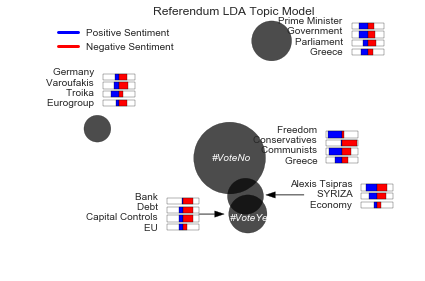

In [164]:
figure_11(10)

Opening: sentiment_entities_elections.json
Topic: 1 sp: 0.35755965769 sn: 0.373355959837
Topic: 2 sp: 0.390014257544 sn: 0.323973549702
Topic: 3 sp: 0.379433365124 sn: 0.362997489276
Topic: 4 sp: 0.396002489769 sn: 0.37630665376
Topic: 5 sp: 0.357806224252 sn: 0.327801068593
0.180988365786 0.285726165821
-0.300245973359 -0.0319772057247
-0.301189154145 0.0446347268747
0.179286977571 -0.38930676393
0.241159784147 0.090923076959
Output filename: plot_4_elections.png
Output filename: plot_4_elections.pdf
Output filename: plot_4_elections.eps


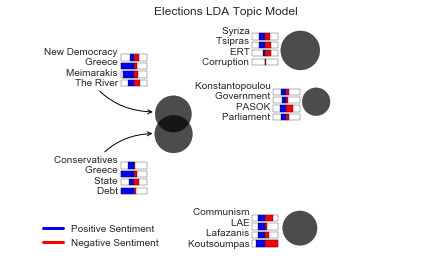

In [168]:
figure_11(11)